# Error analysis notebook

## Import packages

In [1]:
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch


## Set filepaths

In [2]:
ranking = '../evaluation/resources/2020/jsonruns/p_controller_default_nle_meta_9_1_theta=0.9.json'
eval_result = '../evaluation/resources/2020/eval_results/p_controller_default_nle_meta_9_1_theta=0.9.tsv'
gt = '../pre_processing/resources/evaluation/2020/TREC-Fair-Ranking-eval-sample.json'

## Prepare dataframes

In [3]:
# ranking df
rdf = pd.read_json(ranking, lines=True)

# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]

# eval result df
edf = pd.read_csv(eval_result, sep='\t', names=['key', 'qid', 'value'])
edf = edf.pivot(index='qid', columns='key', values='value')

In [4]:
rdf.head(2)

q_num   qid                                            ranking
0    0.0  9087  [c68374b97eb2c214afd3c282175f664fc37c5682, 008...
1    0.1  9087  [cbc33164f9db97698901f130f399f2898d856267, 008...

In [5]:
gtdf.head(2)

qid             query  frequency  \
0  9087  lepidium sativum   0.000013   
0  9087  lepidium sativum   0.000013   

                                           documents  \
0  {'doc_id': '40d8bea494d4ff4c46f7ad5cb2dcdaa6f9...   
0  {'doc_id': '008a2a2c765485af2e035a2572ba9fc110...   

                                     doc_id  doc_rel  
0  40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4        1  
0  008a2a2c765485af2e035a2572ba9fc1102eabff        1

In [6]:
reldf.head(2)

qid             query                                    doc_id  doc_rel
0  9087  lepidium sativum  40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4        1
0  9087  lepidium sativum  008a2a2c765485af2e035a2572ba9fc1102eabff        1

In [7]:
edf.head(2)

key  difference  disparity  relevance
qid                                  
95     0.351999   2.936763   1.949844
612    0.991691   1.731472   1.256254

## Select queries/rankings to inspect

[1] select the queries/rankings to inspect based on the MAP value of the rankings. One of the criteria is to select queries whose ranking's MAP is lower than the average for all queries/systems. We do something similar by looking at queries for which the DGEE is lower than average. 

The worst ten queries are:

In [8]:
edf[edf.difference > edf.difference.mean()].sort_values(by='difference',ascending=False).head(10)

key     difference  disparity  relevance
qid                                     
657       3.700546   2.631709   0.255715
100510    3.252370   2.703133   0.514383
16607     3.034450   2.557715   0.550634
89881     1.987253   1.570899   0.577918
12885     1.941179   1.874742   0.848831
18060     1.725684   1.519402   0.684165
59483     1.619563   1.586472   0.469430
52501     1.429890   1.625181   0.943276
89569     1.210698   1.378091   0.572047
2438      1.193136   1.397599   0.397092

In [9]:
edf.sort_values(by='difference',ascending=True).head(10)

key    difference  disparity  relevance
qid                                    
91643    0.019822   1.006921   0.868206
5191     0.044683   1.448939   1.344147
81479    0.046552   2.044160   1.889465
21237    0.053041   1.358547   1.149610
7363     0.053171   1.313280   1.085770
18112    0.057675   1.327767   1.079491
61688    0.061505   1.061153   0.834400
4319     0.063171   1.892463   1.585866
43723    0.065366   1.839158   1.496630
51335    0.071198   1.577270   1.252222

## Extract information for specific query

In [10]:
def extract_results_based_on_qid(qid, ranking_df):
    return ranking_df[ranking_df.qid == qid]

def extract_relevances_based_on_qid(qid, relevance_df):
    return relevance_df[relevance_df.qid == qid]

In [11]:
extract_results_based_on_qid(657, rdf).head(5)

q_num  qid                                            ranking
24150  161.0  657  [1436449e0234166b13135df45be1f072df059007, 863...
24151  161.1  657  [18f883bd5b9ab9771e561a0214af6bd5ddda0d61, 863...
24152  161.2  657  [e9cfbf58d87e9f5afae813e8b8294b7719c176da, b79...
24153  161.3  657  [128611b63b268a1bffb69d3276a11ae7f6b068d7, 3c9...
24154  161.4  657  [e686c4e74d9085c78813355d582102d973b157cf, b79...

In [12]:
extract_relevances_based_on_qid(657, reldf).head(5)

qid query                                    doc_id  doc_rel
161  657  iran  a1b0feb1f82716b0e343453ca214912cfd3ea0e5        0
161  657  iran  b59004dc46558189fa4d846029ccb1ce3f079484        0
161  657  iran  17475d93c5d0b5b6396aa1d3a3928d6154b65695        0
161  657  iran  1436449e0234166b13135df45be1f072df059007        0
161  657  iran  18f883bd5b9ab9771e561a0214af6bd5ddda0d61        0

## Visualization: rel/nonrel position distribution

We visualize how often a ranking position is occupied by a relevant versus a non-relevant document, aggregated over all 150 returned rankings for that query.


In [67]:
def count_relgrades(relevance_df):
    rel_counts = relevance_df.doc_rel.value_counts()
    rel_count = rel_counts[1]
    nonrel_count = rel_counts[0]
    return rel_count, nonrel_count

In [68]:
def count_relgrades_qid(qid, relevance):
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    return count_relgrades(subrelevance)
    

In [15]:
def count_rel_nonrel_per_rank(rankings_df, relevance_df):
    """rankings_df and relevance_df should already be reduced to the information for a single qid"""
    countdict = {k :{'r':0,'nr':0} for k in range(1,len(rankings_df['ranking'].iloc[0]) + 1)}
    for idx, row in rankings_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            rel = relevance_df[relevance_df.doc_id == doc].doc_rel.iloc[0]
            if rel == 0:
                countdict[i+1]['nr'] = countdict[i+1]['nr'] + 1
            elif rel == 1:
                countdict[i+1]['r'] = countdict[i+1]['r'] + 1
            else:
                raise ValueError
    return countdict
            

In [16]:
def rel_nonrel_per_rank_counts_to_sns_df(countdict):
    unpacked = [record for reclist in [[{**{'rank':k},**{'relkind':k2,'count':v2}} for k2,v2 in v.items()] for k,v in countdict.items()] for record in reclist]
    return pd.DataFrame(unpacked)

In [17]:
def count_doc_occurrence_per_rank(rankings_df):
    """Count how often each document occurs at each rank."""
    count_per_doc_per_rank = {i: {} for i in list(range(1,len(rankings_df['ranking'].iloc[0]) + 1))}

    for idx, row in rankings_df.iterrows():
        for j, doc in enumerate(row['ranking']):
            i = j + 1
            if not doc in count_per_doc_per_rank[i]:
                count_per_doc_per_rank[i][doc] = 0
            count_per_doc_per_rank[i][doc] = count_per_doc_per_rank[i][doc] + 1
    return count_per_doc_per_rank

In [18]:
def doc_occurrence_per_rank_to_sns_df(occurrence_dict, relevance_df):
    unpacked = [d for dlist in [[{'rank':k, 'doc_id':k2, 'count':v2} for k2, v2 in v.items()] for k,v in occurrence_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

In [19]:
def count_pos_of_documents(ranking_df, num_relevant_docs):
    doc_pos_count_dict = {}

    for idx, row in ranking_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            if not doc in doc_pos_count_dict:
                doc_pos_count_dict[doc] = {"top": 0, "bot": 0}
            if i < num_relevant_docs:
                doc_pos_count_dict[doc]["top"] = doc_pos_count_dict[doc]["top"] + 1
            else:
                doc_pos_count_dict[doc]["bot"] = doc_pos_count_dict[doc]["bot"] + 1

    return doc_pos_count_dict        

In [20]:
def document_pos_count_to_sns_df(doc_pos_count_dict, relevance_df):
    unpacked = [d for dlist in [[{'doc_id':k, 'pos':k2, 'count':v2} for k2, v2 in v.items()] for k,v in doc_pos_count_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

In [21]:
def plot_rel_nonrel_per_rank(data):
    """Plot the number of times a (non)relevant item appeared at a rank."""
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(x="rank", y="count", hue="relkind", data=data)

In [22]:
def plot_rel_nonrel_per_rank_per_relkind(data,plotkind='bar'):
    """Plot the number of times a (non)relevant item appeared at a rank, split by rank."""
    
    pi = iter(sns.color_palette())
    
#     fig = plt.figure()
    fig, ax = plt.subplots(1,2,figsize = (17.7,8.27))
    ax[0].title.set_text('Relevant item counts')
    ax[1].title.set_text('Nonrelevant item counts')
    
    if plotkind =='bar':
        sns.barplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0],color=next(pi))
        sns.barplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1],color=next(pi))
        
    if plotkind =='hist':
        sns.histplot(data=data[data.relkind=='r'], x="rank",weights=data[data.relkind=='r']["count"],binwidth=0.99,kde=True,ax=ax[0],color=next(pi))
        sns.histplot(data=data[data.relkind=='nr'], x="rank",weights=data[data.relkind=='nr']["count"],binwidth=0.99,kde=True,ax=ax[1],color=next(pi))

In [23]:
def plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, plotkind='bar'):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subranking, subrelevance)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,plotkind=plotkind)
    

In [24]:
def plot_doc_occurrence_per_rank(data, k=2, rev=False):
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)
    
    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")
    
#     numrows = math.ceil(num_rel_docs / 2)
    fig, ax = plt.subplots(1, k, figsize = (18, 8))
    
    for i in range(0,k):
        rank = i + 1
        if rev:
            rank = len(set(data["rank"].to_list())) - rank
    
        thisaxdata = data[data['rank'] == rank].sort_values(by='count',ascending=False)
        
    
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        ax[i].title.set_text(f'Rank {rank}')
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
    return fig

In [25]:
def plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance, k=2, rev=False):
        subranking = extract_results_based_on_qid(qid, ranking)
        subrelevance = extract_relevances_based_on_qid(qid, relevance)
                
        doc_per_rank_counts = count_doc_occurrence_per_rank(subranking)
        rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subrelevance)
    
        fig = plot_doc_occurrence_per_rank(rank_occurrence_df, k,rev)
        fig.suptitle(f"Document counts per rank for {qid}")
    
    

In [26]:
def plot_doc_pos_count(data):
    """Plot how many times each document occurred in the top and bottom positions."""
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)

    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")


    fig, ax = plt.subplots(1, 2, figsize = (18, 8))
    _ = ax[0].title.set_text(f'Occurrence of doc in top pos (k={rel_count})')
    _ = ax[1].title.set_text(f'Occurrence of doc in bottom pos (k={nonrel_count})')

    for i, pos in enumerate(["top","bot"]):
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        thisaxdata = data[data['pos'] == pos]
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)


In [27]:
def plot_doc_pos_count_for_qid(qid, ranking, relevance):
        subranking = extract_results_based_on_qid(qid, ranking)
        subrelevance = extract_relevances_based_on_qid(qid,relevance)
        num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
        doc_position_counts = count_pos_of_documents(subranking, rel_count)
        doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subrelevance)
        plot_doc_pos_count(doc_pos_count_df)

    

In [28]:
def plots_for_qid(qid,ranking,relevance,k=2):
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, plotkind='hist')
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, plotkind='bar')

    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k)
    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k,rev=True)
    plot_doc_pos_count_for_qid(qid, ranking, relevance)

In [29]:
plotoptions_qid = ["plot_rel_nonrel_per_rank_per_relkind_for_qid","plot_doc_occurrence_per_rank_for_qid","plot_doc_pos_count_for_qid"]

### QID: 657

In [30]:
qid = 657
subrdf = extract_results_based_on_qid(qid, rdf)
subreldf = extract_relevances_based_on_qid(qid,reldf)

In [31]:
rel_counts = subreldf.doc_rel.value_counts()
rel_count = rel_counts[1]
nonrel_count = rel_counts[0]

In [32]:
rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)

In [33]:
rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
rel_nonrel_df.head(4)

rank relkind  count
0     1       r      1
1     1      nr    149
2     2       r      7
3     2      nr    143

We plot the number of relevant/nonrelevant items that appear at each rank. An issue with this approach is that most rankings contain more nonrelevant than relevant items. As a result, there bars for the nonrelevant items are on a different scale than those for the relevant items. This makes the plot harder to read.

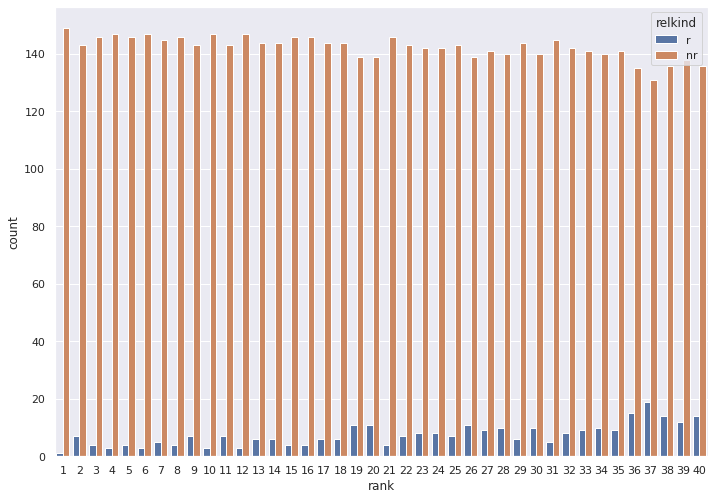

In [34]:
plot_rel_nonrel_per_rank(rel_nonrel_df)

We split the plot into relevant and nonrelevant item counts for readability.

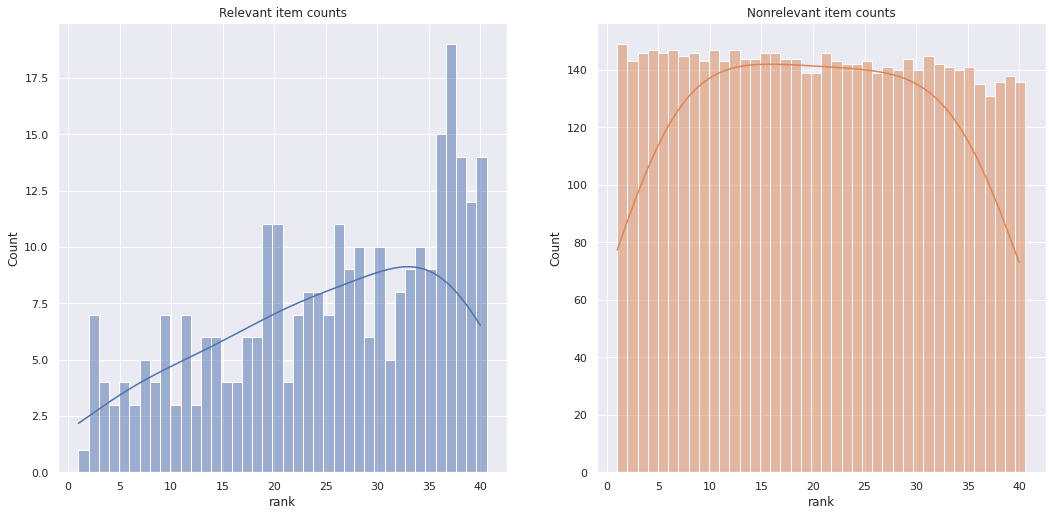

In [35]:
plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,plotkind='hist')

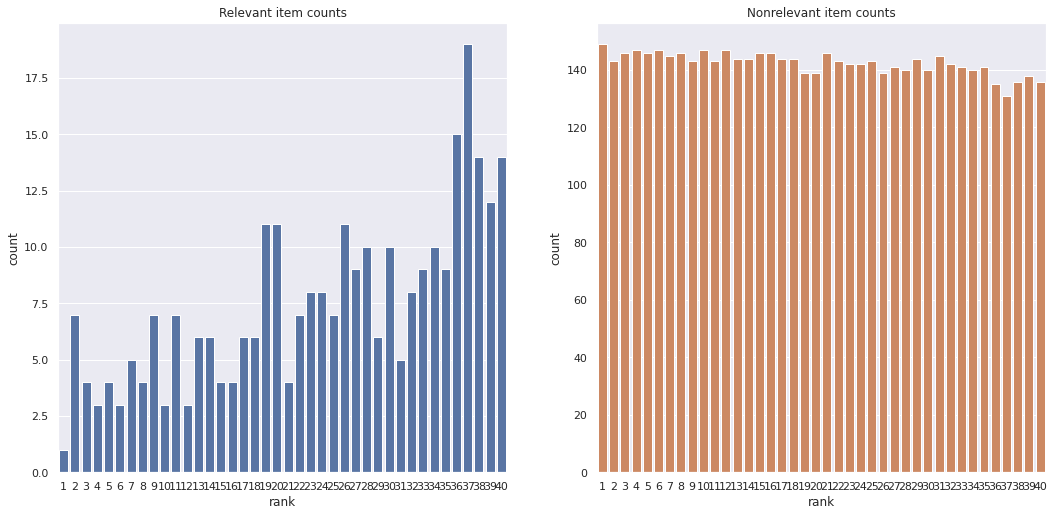

In [36]:
plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,plotkind='bar')

We immediately see an interesting pattern in the distribution of the relevant items across the ranking positions. We see that the number of relevant items *increases* with increasing rank. This makes sense for a query that performs poorly, but we don't yet know *why* the relevant items are ranked towards the back. After all, if we ranked completely at random we would expect a uniform distribution instead.

In [37]:
doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)

In [38]:
rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts,subreldf)
rank_occurrence_df.head(4)

rank                                    doc_id  count  doc_rel
0     1  1436449e0234166b13135df45be1f072df059007      7        0
1     1  18f883bd5b9ab9771e561a0214af6bd5ddda0d61      6        0
2     1  e9cfbf58d87e9f5afae813e8b8294b7719c176da      6        0
3     1  128611b63b268a1bffb69d3276a11ae7f6b068d7      5        0

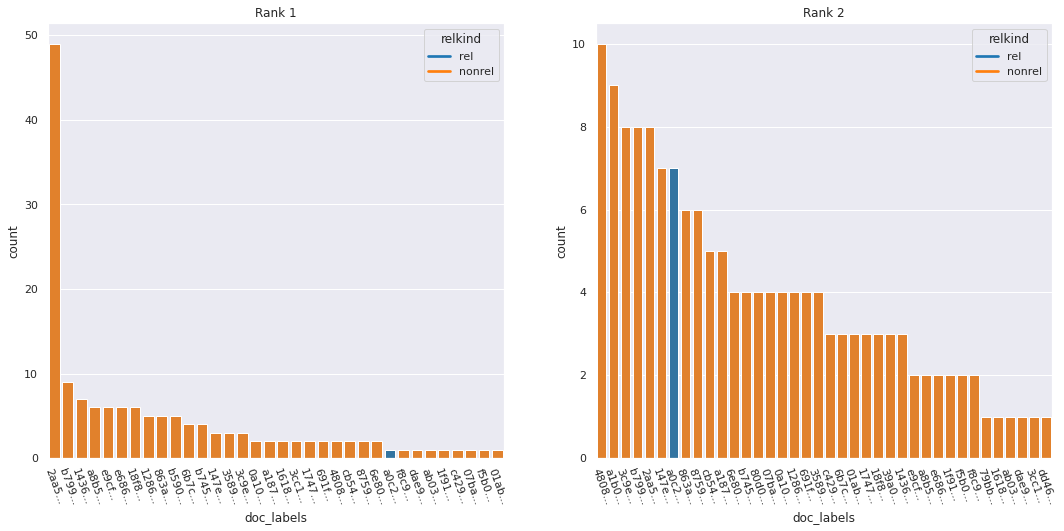

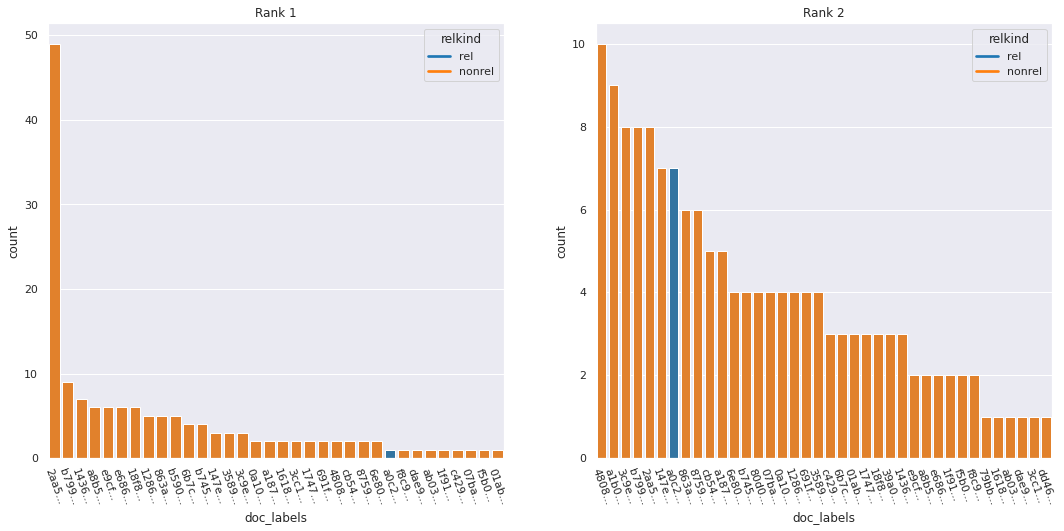

In [39]:
plot_doc_occurrence_per_rank(rank_occurrence_df,2)

In the figures above we see how many times each document was put in the first or second ranking position, aggregated across 150 rankings. The blue line indicates which document is relevant; only one relevant document is put in either the first or second rank, and only one time in the first and 5 times in the second ranking.

How often is each rel file in a top position? How often is it not?

In [40]:
subrdf.head(10)

q_num  qid                                            ranking
24150  161.0  657  [1436449e0234166b13135df45be1f072df059007, 863...
24151  161.1  657  [18f883bd5b9ab9771e561a0214af6bd5ddda0d61, 863...
24152  161.2  657  [e9cfbf58d87e9f5afae813e8b8294b7719c176da, b79...
24153  161.3  657  [128611b63b268a1bffb69d3276a11ae7f6b068d7, 3c9...
24154  161.4  657  [e686c4e74d9085c78813355d582102d973b157cf, b79...
24155  161.5  657  [a8b58f310e13c171ce7b7890d23860836cbc4534, 143...
24156  161.6  657  [863a0360e4345b2e106e4f44cd95821f68b28036, 3c9...
24157  161.7  657  [87596955211a23714a6c2fc2af2d00464d15f9b3, 480...
24158  161.8  657  [3589a8b05684193dfc55610c9a9fbcf6db490130, 147...
24159  161.9  657  [6b7ca72ca79251cded87c47608e5cc93e37b09f2, b79...

In [41]:
doc_position_counts = count_pos_of_documents(subrdf, rel_count)

In [42]:
doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subreldf)
doc_pos_count_df.head(10)

doc_id  pos  count  doc_rel
0  1436449e0234166b13135df45be1f072df059007  top     10        0
1  1436449e0234166b13135df45be1f072df059007  bot    140        0
2  863a0360e4345b2e106e4f44cd95821f68b28036  top     11        0
3  863a0360e4345b2e106e4f44cd95821f68b28036  bot    139        0
4  e9cfbf58d87e9f5afae813e8b8294b7719c176da  top      8        0
5  e9cfbf58d87e9f5afae813e8b8294b7719c176da  bot    142        0
6  18f883bd5b9ab9771e561a0214af6bd5ddda0d61  top      9        0
7  18f883bd5b9ab9771e561a0214af6bd5ddda0d61  bot    141        0
8  3c9ee8bdf45ad8d8dff26eab50c2fa13083c2cec  top     11        0
9  3c9ee8bdf45ad8d8dff26eab50c2fa13083c2cec  bot    139        0

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


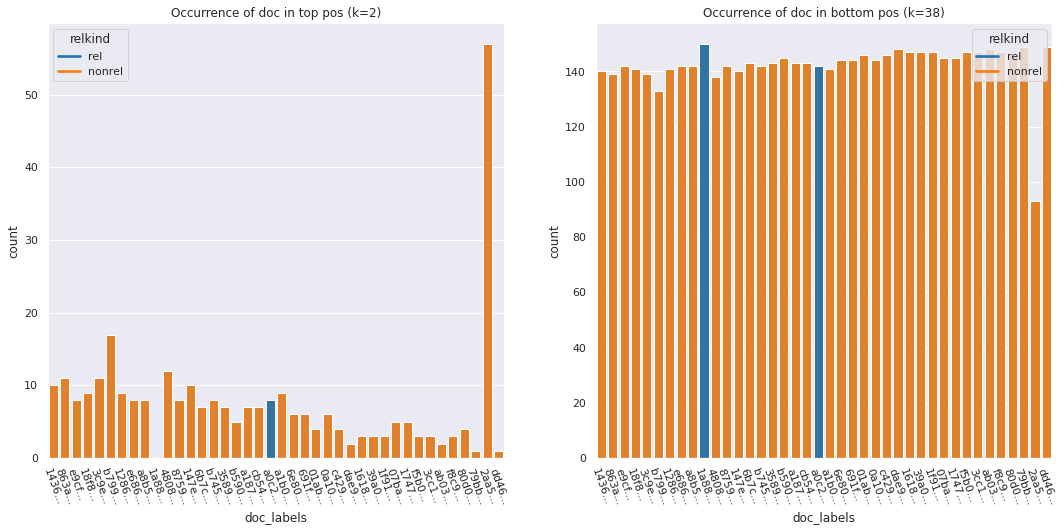

In [43]:
plot_doc_pos_count(doc_pos_count_df)


Let's compare multiple queries.

0    38
1     2
Name: doc_rel, dtype: int64
0    8
1    2
Name: doc_rel, dtype: int64
0    8
1    2
Name: doc_rel, dtype: int64
0    8
1    2
Name: doc_rel, dtype: int64
0    28
1     3
Name: doc_rel, dtype: int64


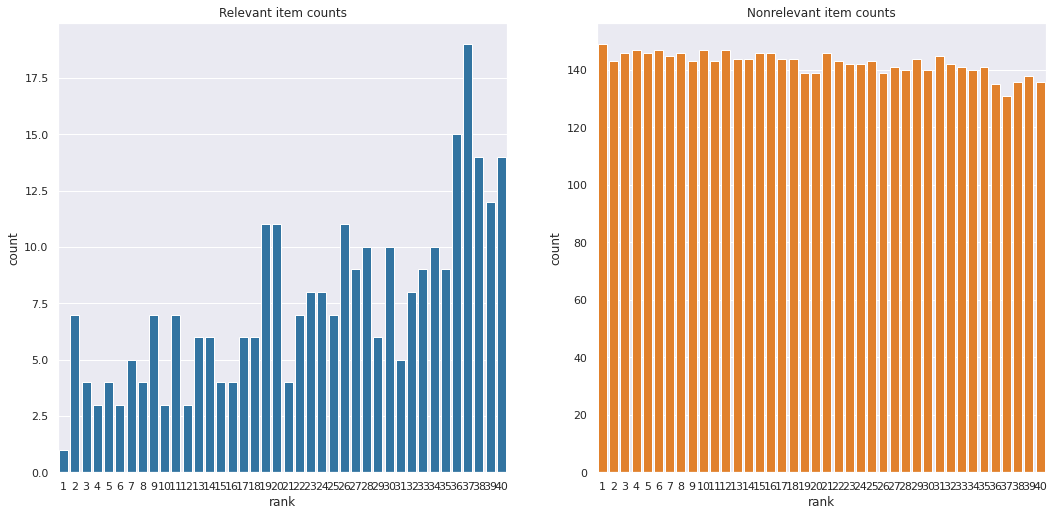

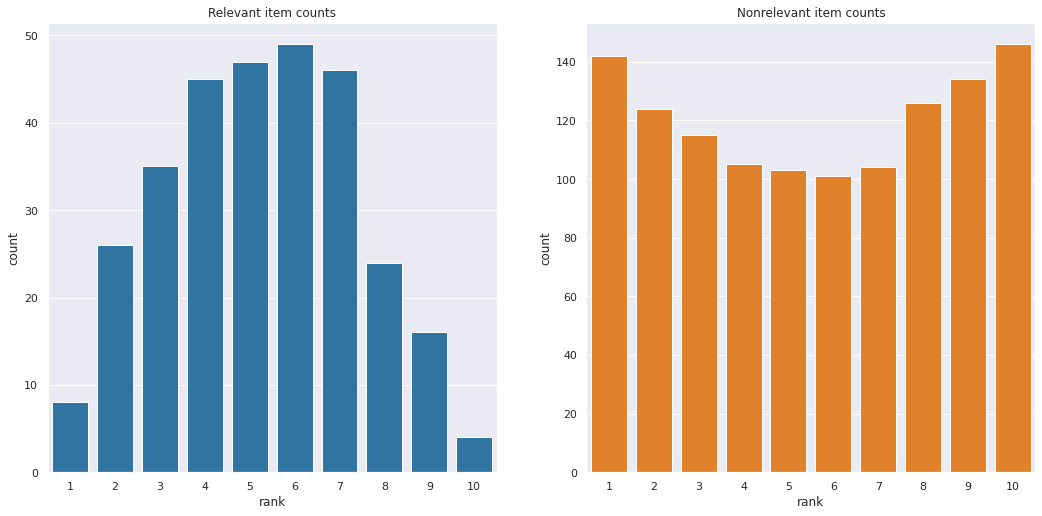

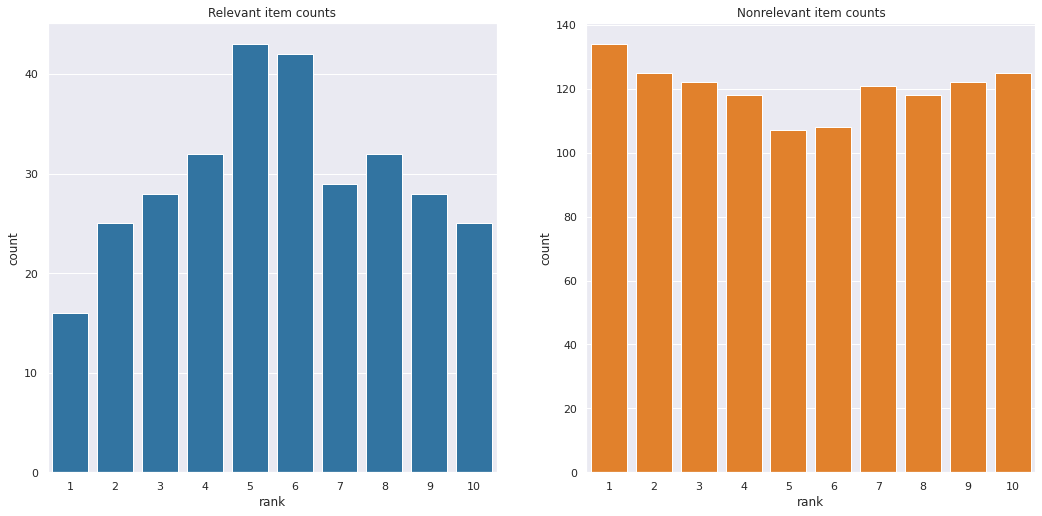

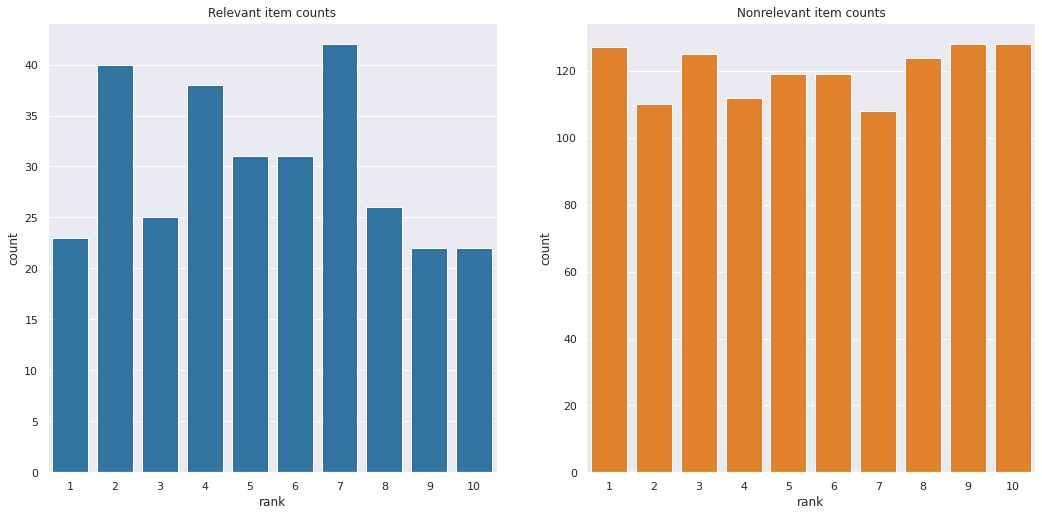

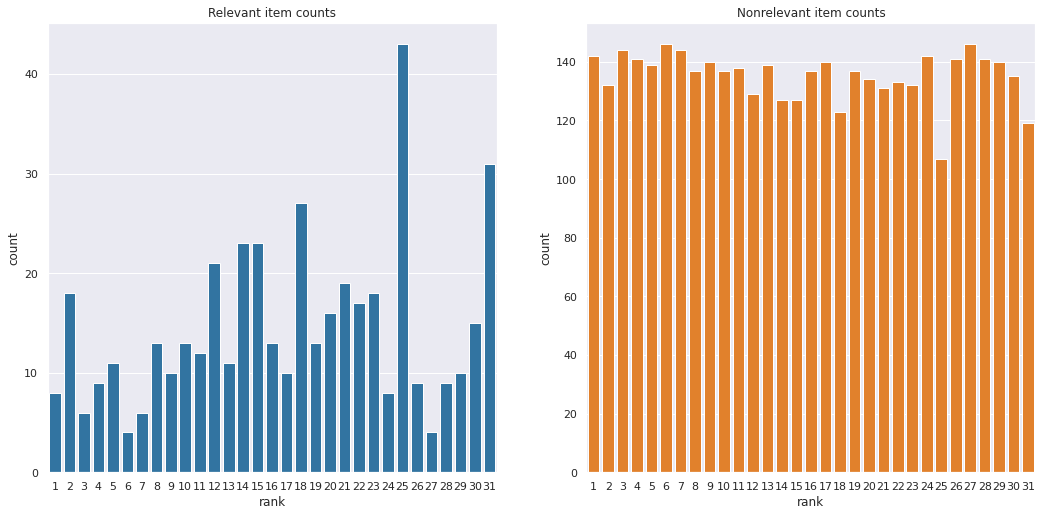

In [44]:
plot_rel_nonrel_per_rank_per_relkind_for_qid(657,rdf,reldf)
plot_rel_nonrel_per_rank_per_relkind_for_qid(100510,rdf,reldf)
plot_rel_nonrel_per_rank_per_relkind_for_qid(16607,rdf,reldf)
plot_rel_nonrel_per_rank_per_relkind_for_qid(89881,rdf,reldf)
plot_rel_nonrel_per_rank_per_relkind_for_qid(12885,rdf,reldf)


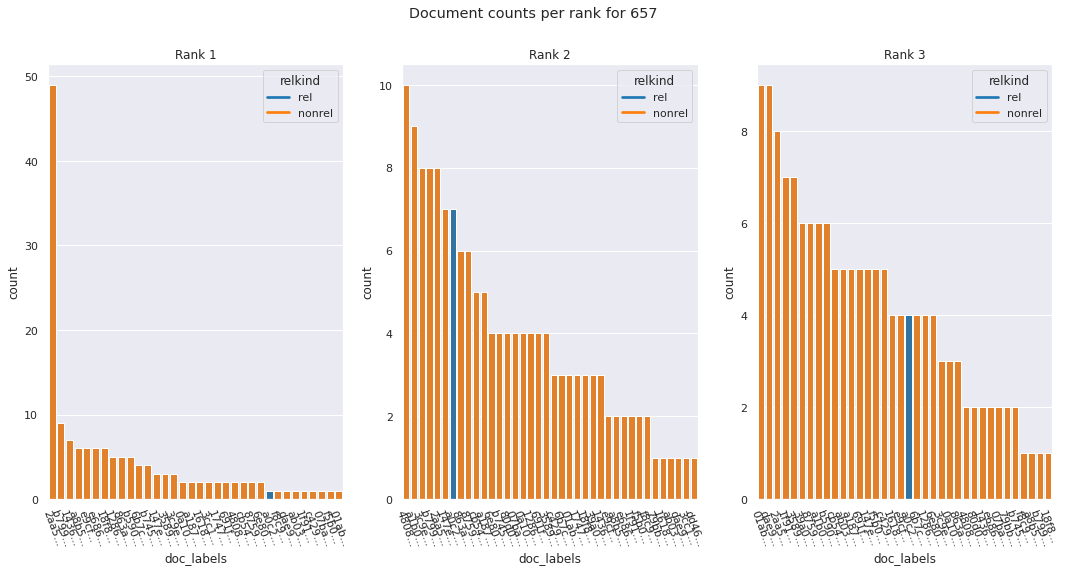

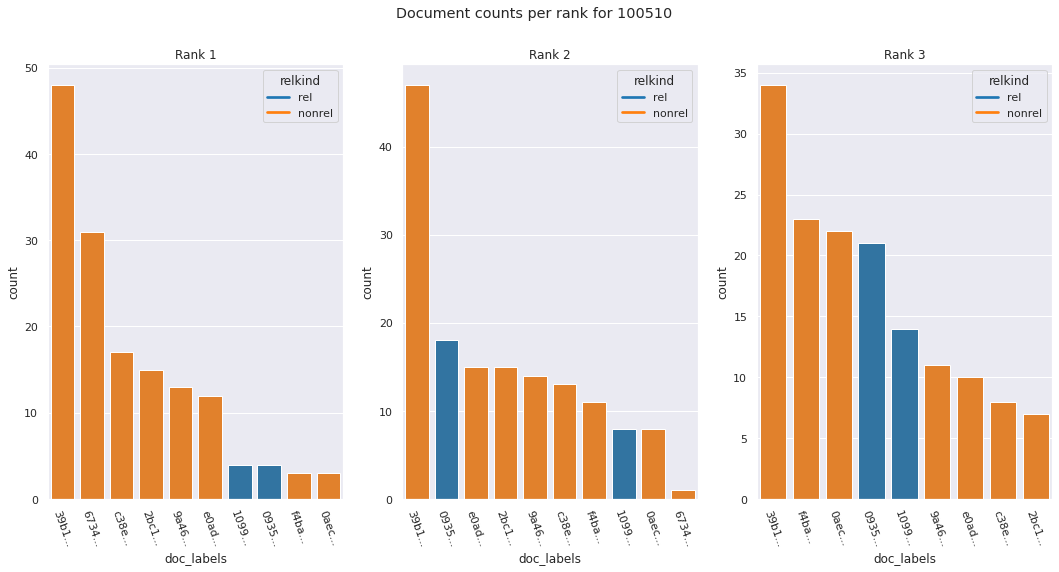

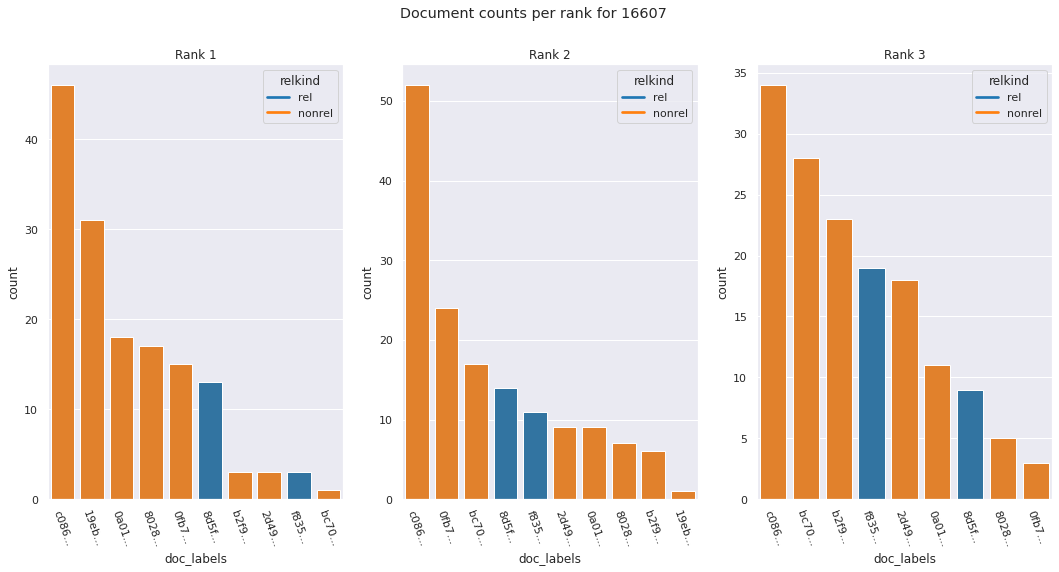

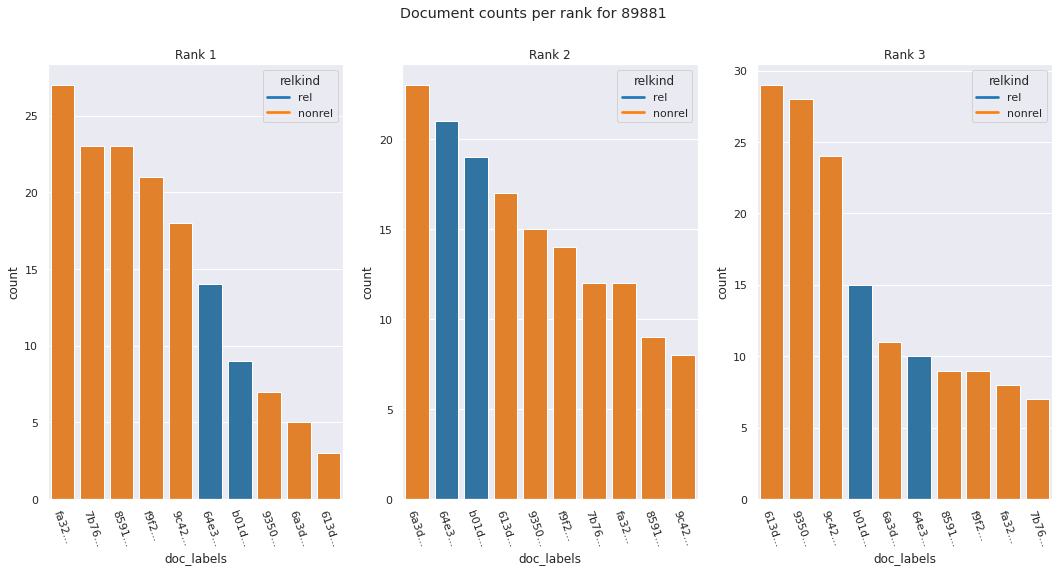

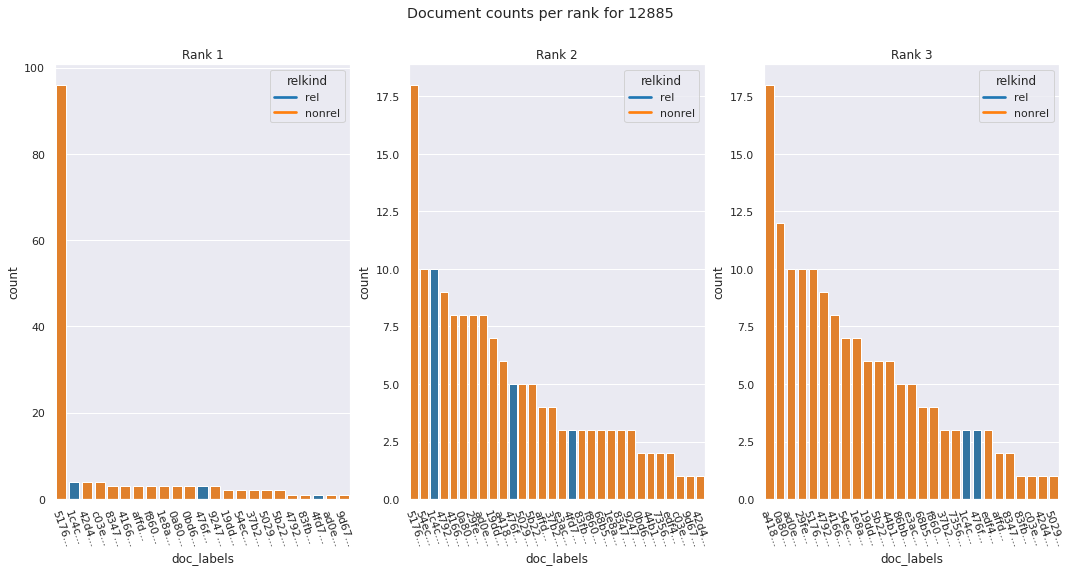

In [45]:
plot_doc_occurrence_per_rank_for_qid(657,rdf,reldf,k=3)
plot_doc_occurrence_per_rank_for_qid(100510,rdf,reldf,k=3)
plot_doc_occurrence_per_rank_for_qid(16607,rdf,reldf,k=3)
plot_doc_occurrence_per_rank_for_qid(89881,rdf,reldf,k=3)
plot_doc_occurrence_per_rank_for_qid(12885,rdf,reldf,k=3)


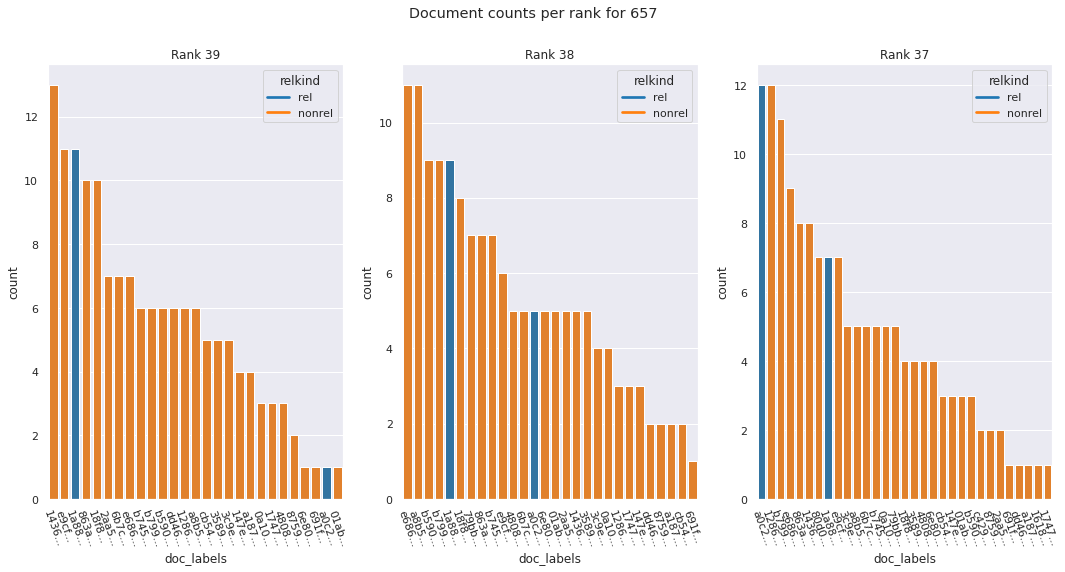

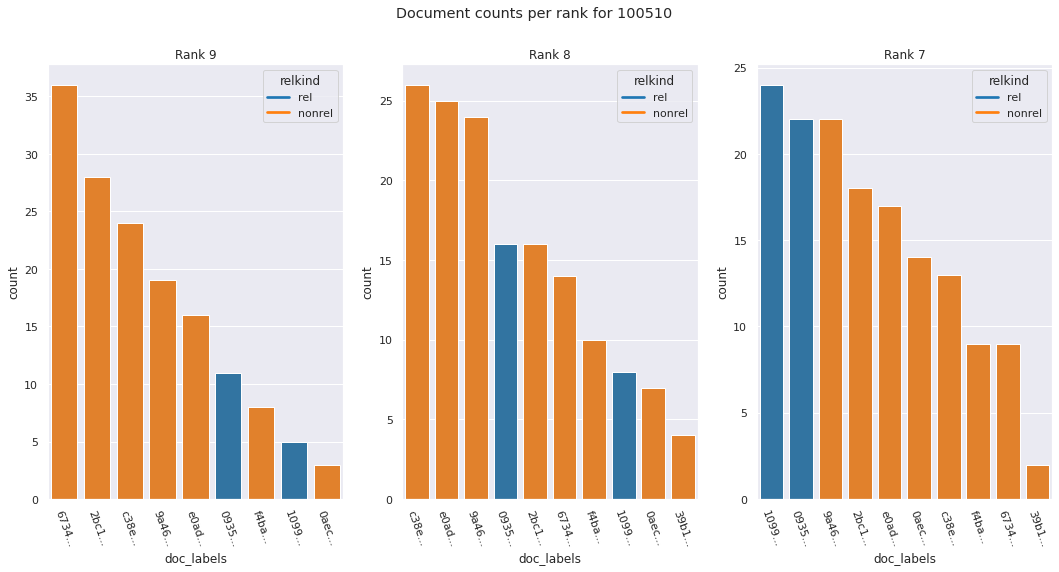

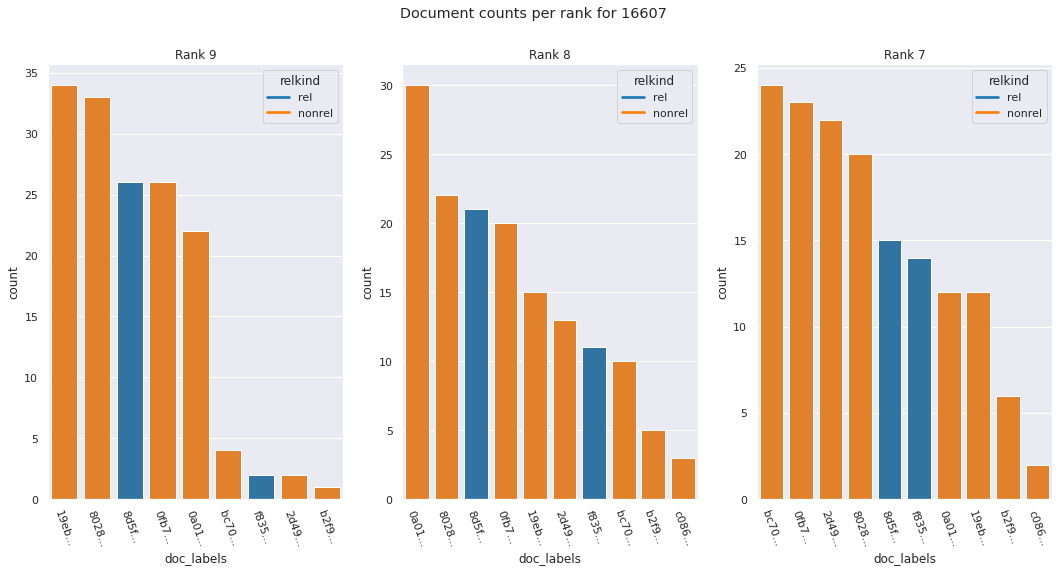

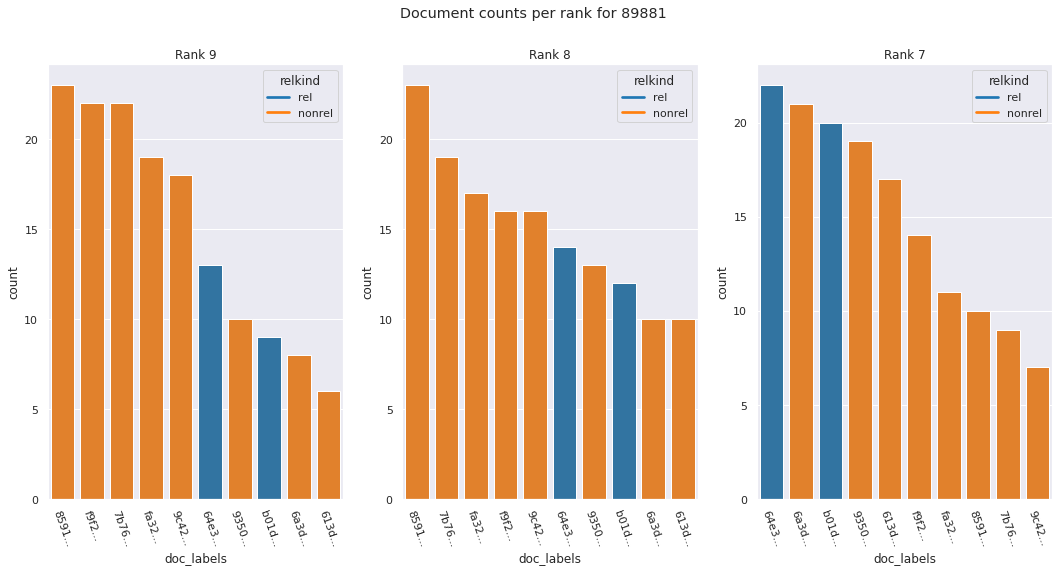

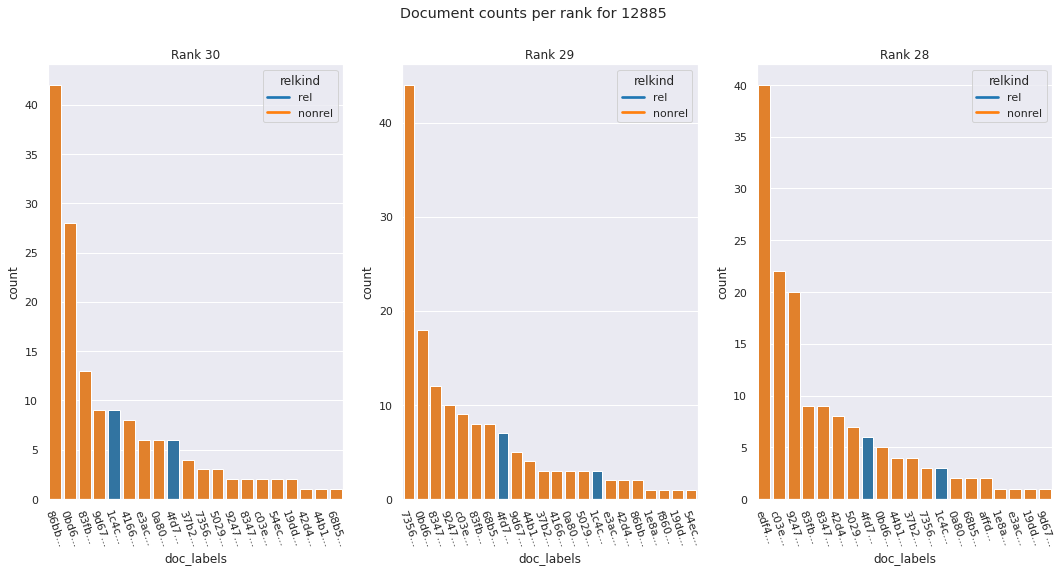

In [46]:
plot_doc_occurrence_per_rank_for_qid(657,rdf,reldf,k=3,rev=True)
plot_doc_occurrence_per_rank_for_qid(100510,rdf,reldf,k=3,rev=True)
plot_doc_occurrence_per_rank_for_qid(16607,rdf,reldf,k=3,rev=True)
plot_doc_occurrence_per_rank_for_qid(89881,rdf,reldf,k=3,rev=True)
plot_doc_occurrence_per_rank_for_qid(12885,rdf,reldf,k=3,rev=True)


In [47]:
count_relgrades_qid(657,reldf)
count_relgrades_qid(100510,reldf)
count_relgrades_qid(16607,reldf)
count_relgrades_qid(89881,reldf)
count_relgrades_qid(12885,reldf)


0    38
1     2
Name: doc_rel, dtype: int64
0    8
1    2
Name: doc_rel, dtype: int64
0    8
1    2
Name: doc_rel, dtype: int64
0    8
1    2
Name: doc_rel, dtype: int64
0    28
1     3
Name: doc_rel, dtype: int64


(3, 28)

0    28
1     3
Name: doc_rel, dtype: int64
0    28
1     3
Name: doc_rel, dtype: int64
0    28
1     3
Name: doc_rel, dtype: int64


/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


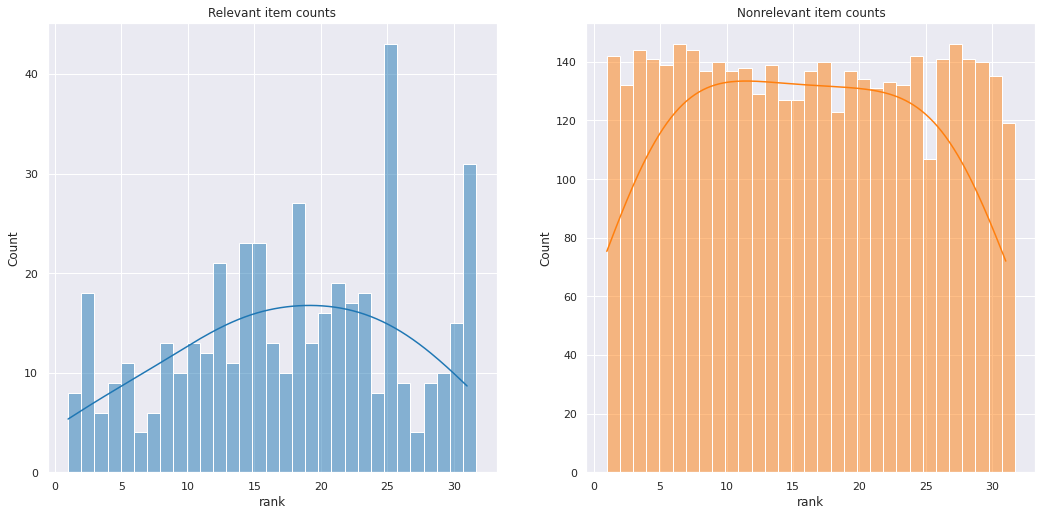

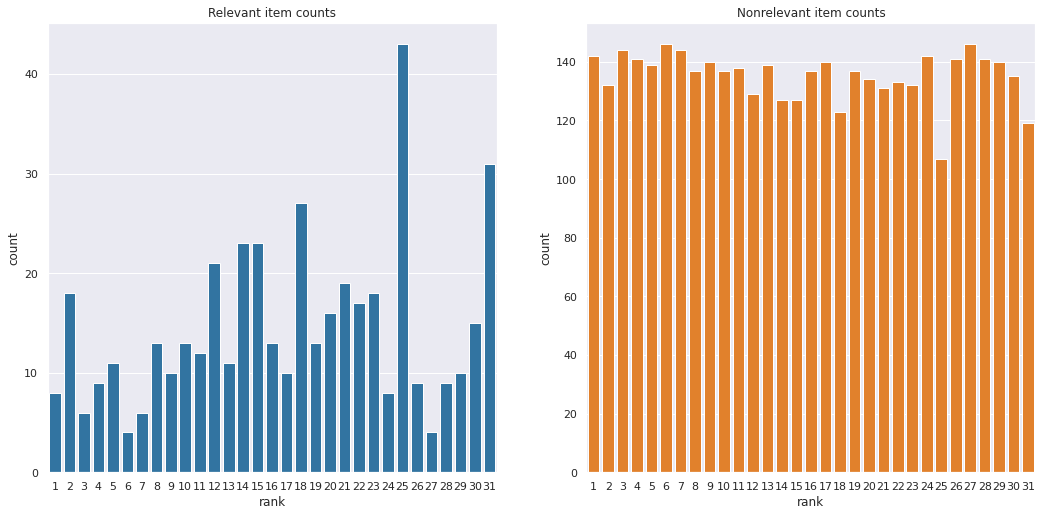

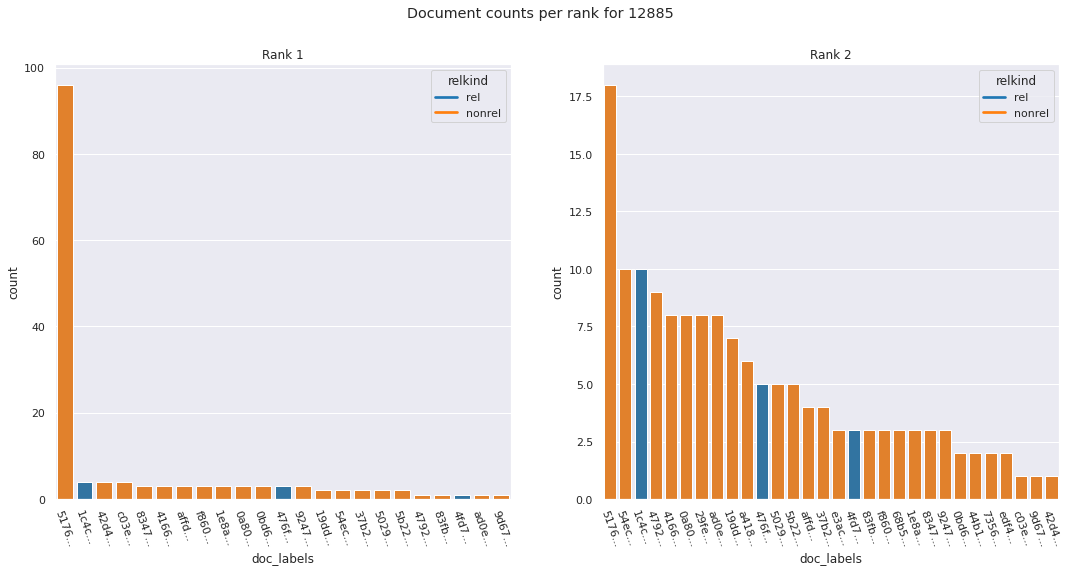

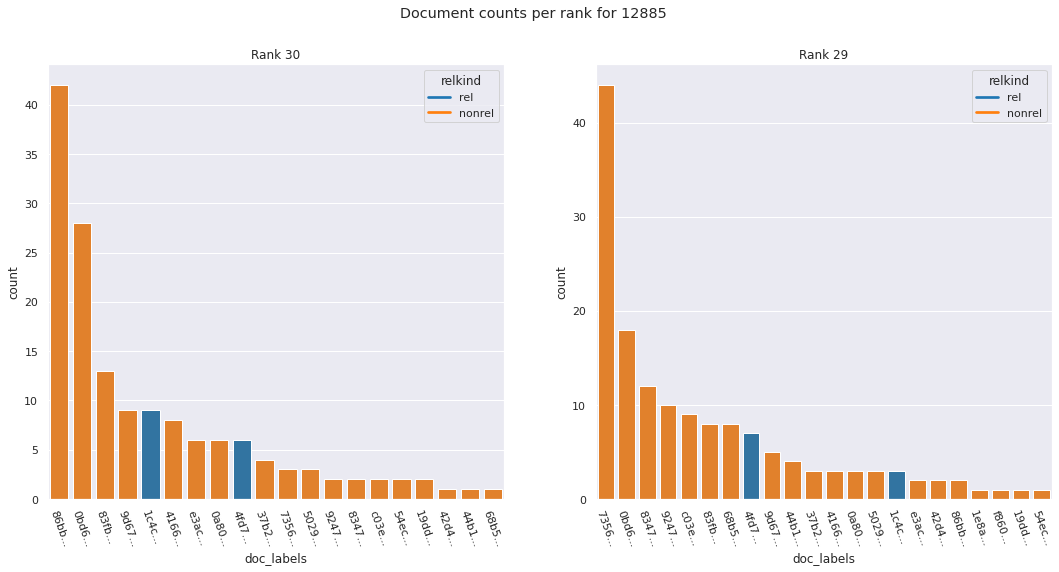

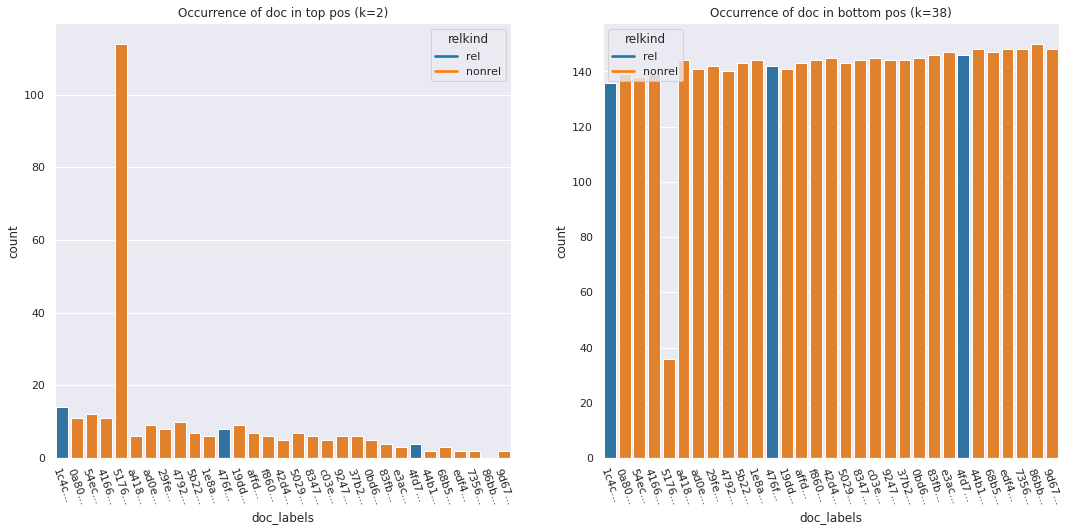

In [48]:
plots_for_qid(12885,rdf,reldf)

0    38
1     2
Name: doc_rel, dtype: int64
0    38
1     2
Name: doc_rel, dtype: int64
0    38
1     2
Name: doc_rel, dtype: int64


/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


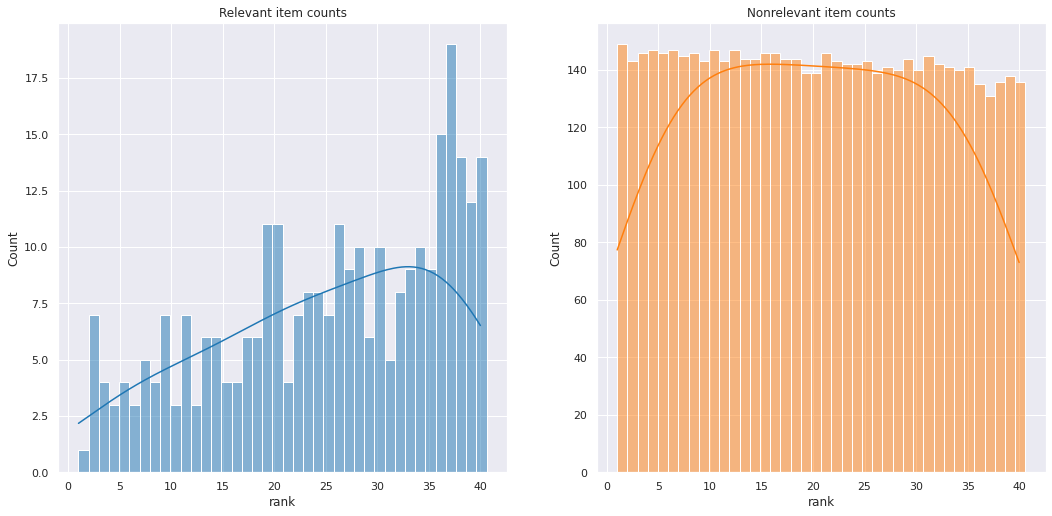

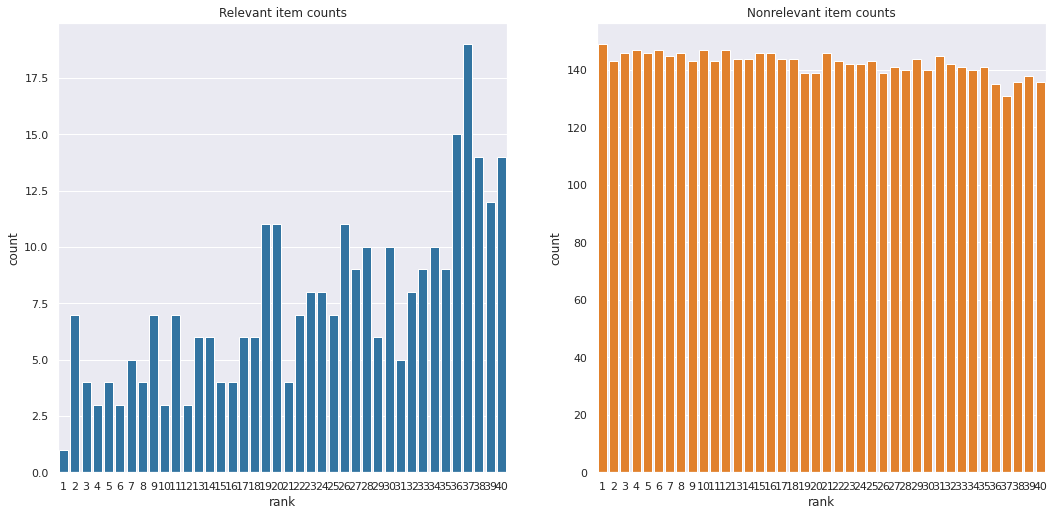

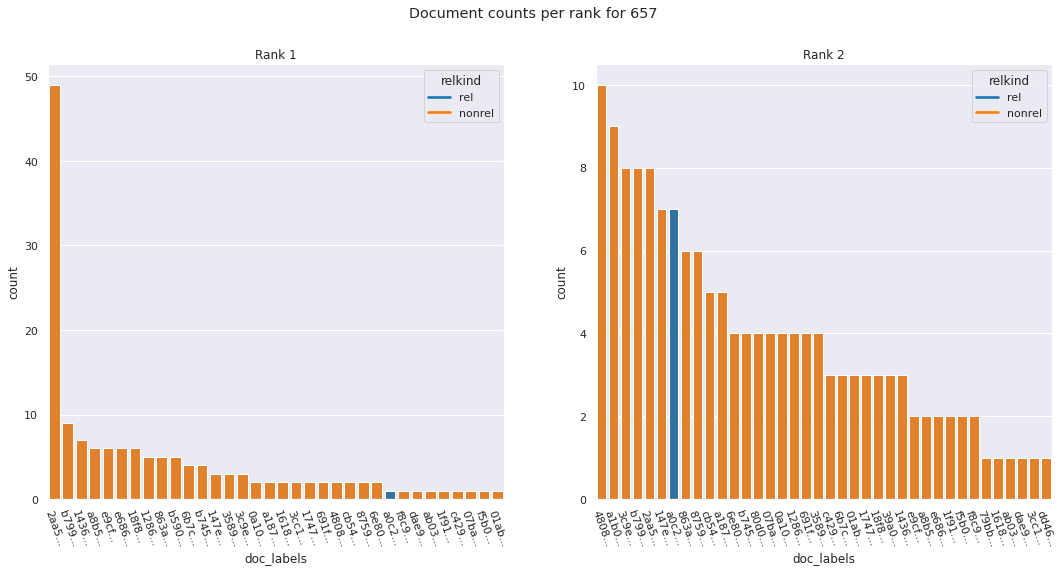

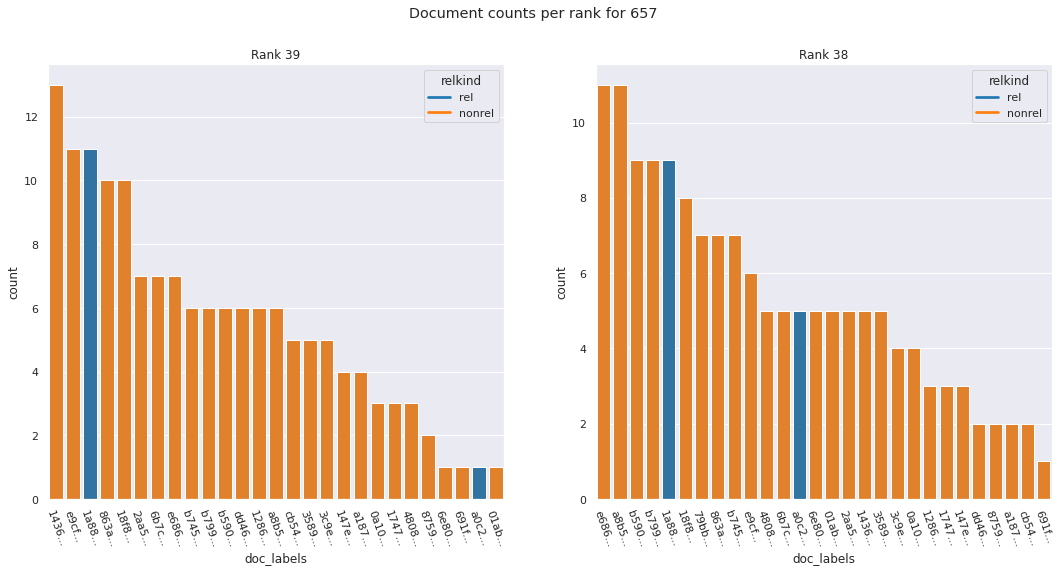

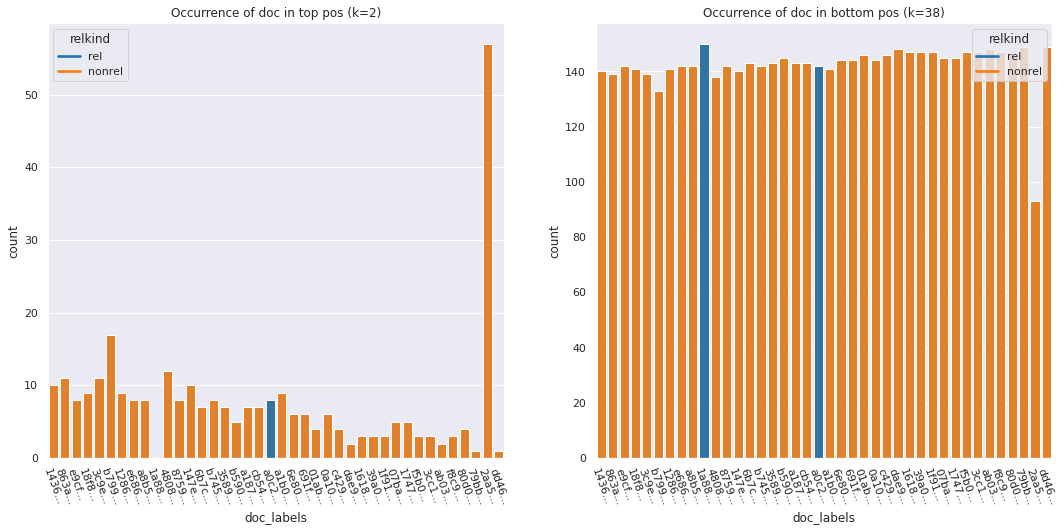

In [49]:
plots_for_qid(657,rdf,reldf)

1    11
0     9
Name: doc_rel, dtype: int64
1    11
0     9
Name: doc_rel, dtype: int64
1    11
0     9
Name: doc_rel, dtype: int64


/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


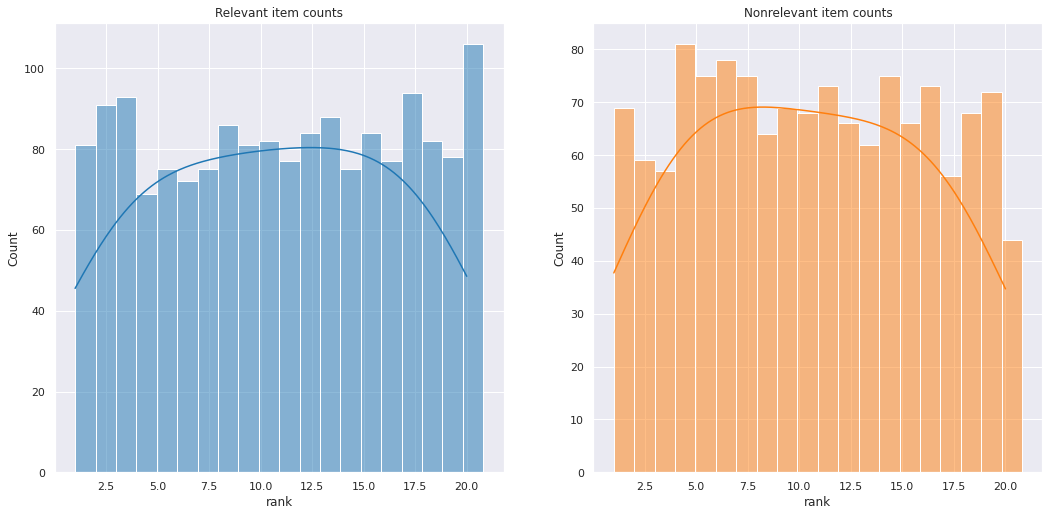

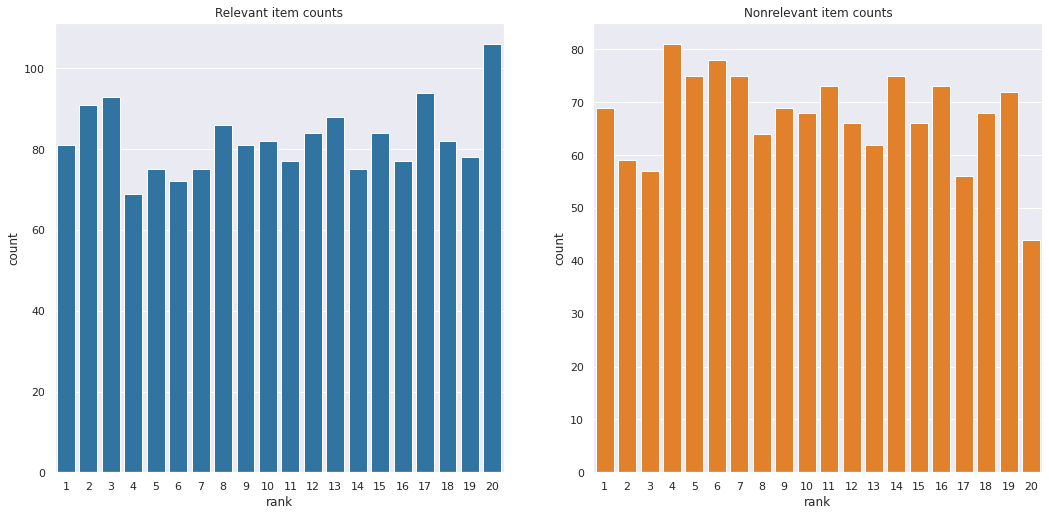

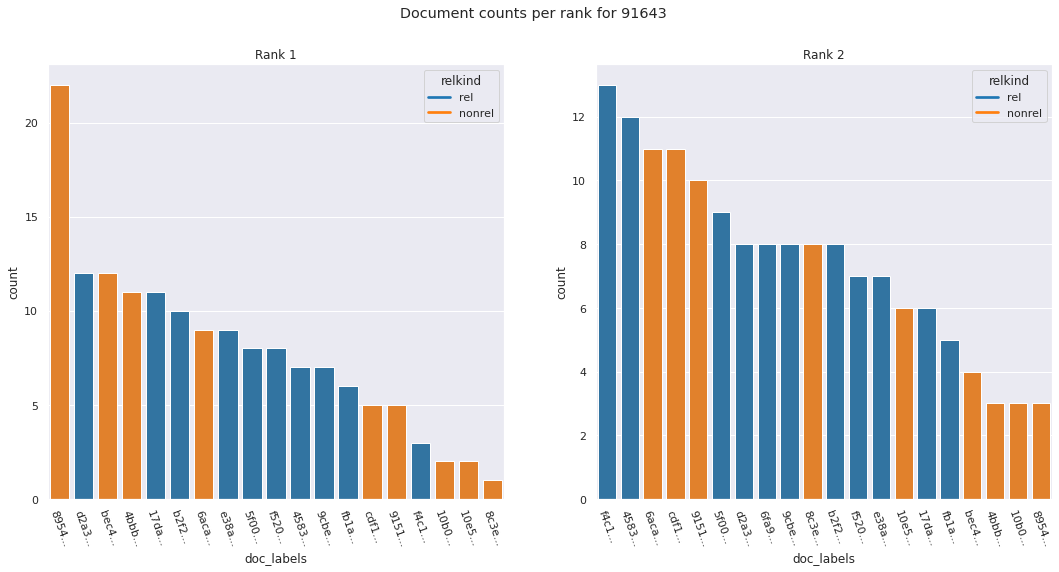

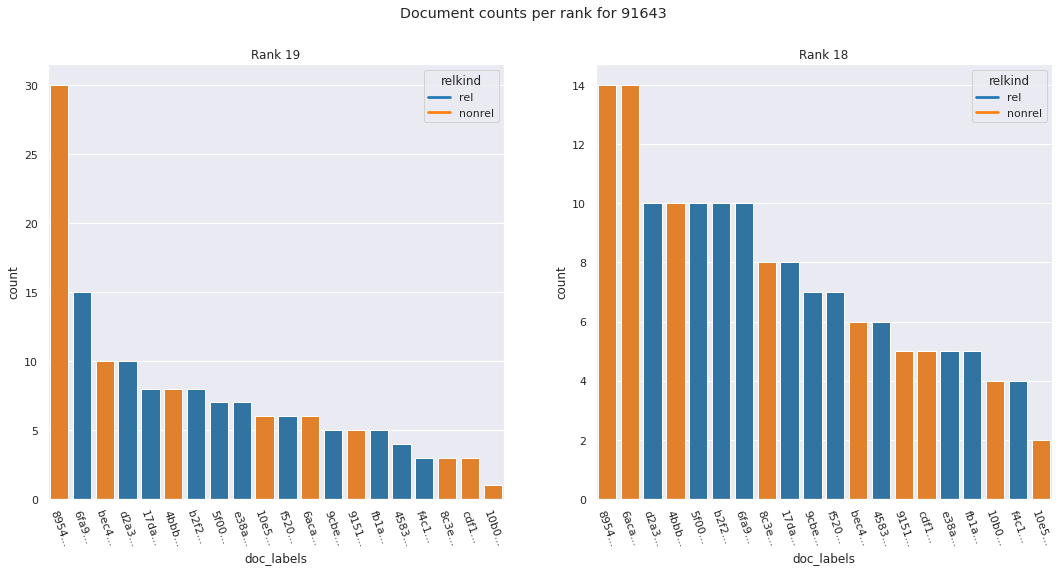

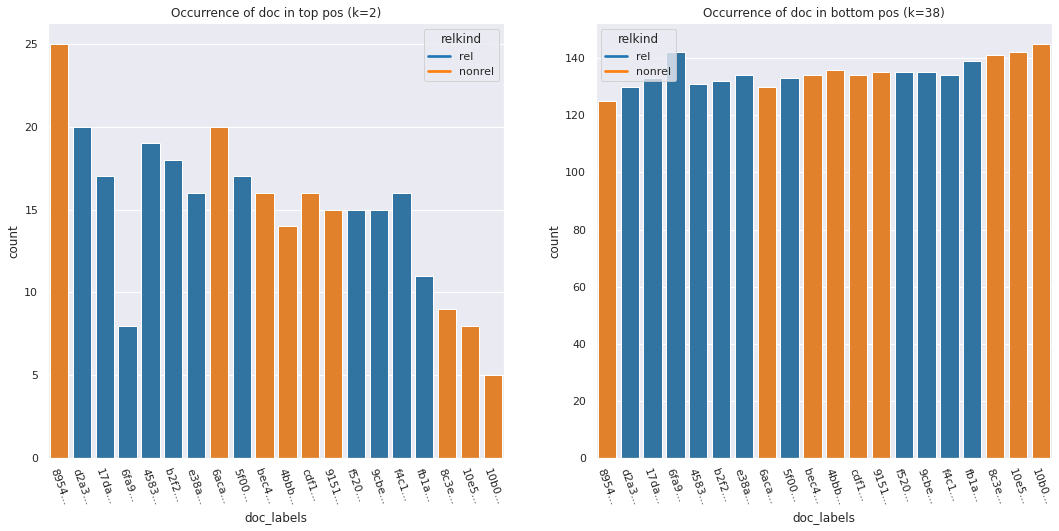

In [50]:
plots_for_qid(91643,rdf,reldf)

In [51]:
reldf[(reldf.qid == 12885) & (reldf.doc_rel == 1)]

qid       query                                    doc_id  doc_rel
141  12885  simulation  476f30d8ed96778b9de0d426d86e4133a9d0c3fc        1
141  12885  simulation  1c4c81d632eba2eae9733de143f83a34b911fa48        1
141  12885  simulation  4fd72cf38d951b2ae92fb1d9b705111335ef84ce        1

In [52]:
reldf[(reldf.qid == 657) & (reldf.doc_rel == 1)]


qid query                                    doc_id  doc_rel
161  657  iran  1a8800cdf999a01022f1db8e5c4c61306d3e43cc        1
161  657  iran  a0c27a04a05676559b89af279dd96dc4232ad4ce        1

In [53]:
reldf[(reldf.qid == 91643) & (reldf.doc_rel == 1)]

qid query                                    doc_id  doc_rel
14  91643  nazi  6fa92e5b2f8d8912026e4e7e6c9a858528499966        1
14  91643  nazi  b2f24606271b959806061c64f81130e5ad75d410        1
14  91643  nazi  fb1a4e990af505ebef7c643c9231645695d9ce31        1
14  91643  nazi  f520d727e7e76253c1d77f26c573474437858593        1
14  91643  nazi  e38a47e6a3e62abf46804dc77b6e1c1deb3eb9e8        1
14  91643  nazi  17dafc3f0318b8711ca4f07783ef428568abb64b        1
14  91643  nazi  5f009ab833e1f9ad39a7d86c70150e80378977f7        1
14  91643  nazi  9cbe474540321289c6c321bc8325f5ac28613c8f        1
14  91643  nazi  f4c12338c303514c5438645404212d95340eeca0        1
14  91643  nazi  d2a334ca26a5849c8aa47057bc19681967eef96b        1
14  91643  nazi  4583fa2cd070ba3305fb856490989a5e2b42dad8        1

In [54]:
reldf[(reldf.qid == 91643) & (reldf.doc_rel == 0)]

qid query                                    doc_id  doc_rel
14  91643  nazi  cdf1901567491b6ad5ecde7042895ec06e99e2b2        0
14  91643  nazi  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        0
14  91643  nazi  4bbb91eb0fea54bd85774931e299efaaaa1b038f        0
14  91643  nazi  8954067bccf3f36cfb46f22c40df207028ecb63a        0
14  91643  nazi  6aca41972c48b8038d3a91c290b3ec032443ec6b        0
14  91643  nazi  9151adf8caa27053bd3bc4adf1390fdfb3205fa2        0
14  91643  nazi  10e5b01d166c37015a92ac938f333a7f0741f596        0
14  91643  nazi  8c3e779d0574a45ee361d66295e34cd0dabbcd37        0
14  91643  nazi  bec4c75f8bf925a5ebcd3976b30cf0790108d5b4        0

- Speculation: queries perform well (poorly) when they have many(few) relevant items?
- Poorly performing queries always have many docs without author

## Hypothesis: queries with many rel vs nonrel items perform well

In [73]:
top10 = edf.sort_values(by='difference',ascending=True).head(10)
top10

key    difference  disparity  relevance
qid                                    
91643    0.019822   1.006921   0.868206
5191     0.044683   1.448939   1.344147
81479    0.046552   2.044160   1.889465
21237    0.053041   1.358547   1.149610
7363     0.053171   1.313280   1.085770
18112    0.057675   1.327767   1.079491
61688    0.061505   1.061153   0.834400
4319     0.063171   1.892463   1.585866
43723    0.065366   1.839158   1.496630
51335    0.071198   1.577270   1.252222

In [74]:
bot10 = edf.sort_values(by='difference',ascending=False).head(10)
bot10

key     difference  disparity  relevance
qid                                     
657       3.700546   2.631709   0.255715
100510    3.252370   2.703133   0.514383
16607     3.034450   2.557715   0.550634
89881     1.987253   1.570899   0.577918
12885     1.941179   1.874742   0.848831
18060     1.725684   1.519402   0.684165
59483     1.619563   1.586472   0.469430
52501     1.429890   1.625181   0.943276
89569     1.210698   1.378091   0.572047
2438      1.193136   1.397599   0.397092

In [166]:
def get_k_results(eval_df,k=10,asc=True):
    sub = eval_df.sort_values(by='difference',ascending=asc).head(k).reset_index()
    return sub

In [167]:
def rel_nonrel_stats_df(eval_df, k=10, asc=True):
#     sub = eval_df.sort_values(by='difference',ascending=asc).head(k).reset_index()
    sub = get_k_results(eval_df,k,asc)
    sub[['r','nr']] = sub.apply(lambda row: count_relgrades_qid(row.qid,reldf), axis='columns', result_type='expand')
    sub[['rfrac','nrfrac']] = sub.apply(lambda row: {'rfrac': row.r / (row.r + row.nr), 'nrfrac': row.nr / (row.r + row.nr) }, axis='columns', result_type='expand')
    return sub

There are 62 items with a difference higher than the total mean, and 138 items with a difference lower than the total mean.

In [168]:
print(edf[edf.difference > edf.difference.mean()].describe())
print()
print(edf[edf.difference <= edf.difference.mean()].describe())

key    difference  disparity  relevance
count   62.000000  62.000000  62.000000
mean     0.960277   1.759598   0.988859
std      0.647813   0.420930   0.328687
min      0.437043   0.998512   0.255715
25%      0.561969   1.469473   0.740174
50%      0.757819   1.671765   1.037014
75%      1.068128   1.899918   1.255380
max      3.700546   2.879598   1.564463

key    difference   disparity   relevance
count  138.000000  138.000000  138.000000
mean     0.190157    1.964270    1.521551
std      0.094710    0.568135    0.452830
min      0.019822    0.985687    0.696810
25%      0.117196    1.623796    1.193393
50%      0.161651    1.865743    1.385916
75%      0.264914    2.230541    1.860925
max      0.409372    3.813899    2.685266


In [169]:
top = rel_nonrel_stats_df(edf, k=138)
bot = rel_nonrel_stats_df(edf, k=62, asc=False)

print(top.rfrac.mean(),'\t',bot.rfrac.mean())
print(top.nrfrac.mean(),'\t',bot.nrfrac.mean())
print()
print(top.head(5),'\n\n', bot.head(5))

0.18171789232594615 	 0.14500607975914462
0.8182821076740538 	 0.8549939202408553

key    qid  difference  disparity  relevance   r  nr     rfrac    nrfrac
0    91643    0.019822   1.006921   0.868206  11   9  0.550000  0.450000
1     5191    0.044683   1.448939   1.344147   6   5  0.545455  0.454545
2    81479    0.046552   2.044160   1.889465   3   7  0.300000  0.700000
3    21237    0.053041   1.358547   1.149610   3  28  0.096774  0.903226
4     7363    0.053171   1.313280   1.085770   2  10  0.166667  0.833333 

 key     qid  difference  disparity  relevance  r  nr     rfrac    nrfrac
0       657    3.700546   2.631709   0.255715  2  38  0.050000  0.950000
1    100510    3.252370   2.703133   0.514383  2   8  0.200000  0.800000
2     16607    3.034450   2.557715   0.550634  2   8  0.200000  0.800000
3     89881    1.987253   1.570899   0.577918  2   8  0.200000  0.800000
4     12885    1.941179   1.874742   0.848831  3  28  0.096774  0.903226


Taking the average across all queries that have a difference lower (higher) than the mean, the items with a lower mean have a higher fraction of relevant items than the items that have a higher mean.

In [170]:
top = rel_nonrel_stats_df(edf,k=20)
bot = rel_nonrel_stats_df(edf,k=20,asc=False)
print(top.rfrac.mean(),'\t',bot.rfrac.mean())
print(top.nrfrac.mean(),'\t',bot.nrfrac.mean())
print()
print(top,'\n\n', bot)


0.3009910461346338 	 0.12824308755760372
0.6990089538653661 	 0.8717569124423964

key    qid  difference  disparity  relevance   r  nr     rfrac    nrfrac
0    91643    0.019822   1.006921   0.868206  11   9  0.550000  0.450000
1     5191    0.044683   1.448939   1.344147   6   5  0.545455  0.454545
2    81479    0.046552   2.044160   1.889465   3   7  0.300000  0.700000
3    21237    0.053041   1.358547   1.149610   3  28  0.096774  0.903226
4     7363    0.053171   1.313280   1.085770   2  10  0.166667  0.833333
5    18112    0.057675   1.327767   1.079491  14  30  0.318182  0.681818
6    61688    0.061505   1.061153   0.834400   4   6  0.400000  0.600000
7     4319    0.063171   1.892463   1.585866   7  13  0.350000  0.650000
8    43723    0.065366   1.839158   1.496630  11  22  0.333333  0.666667
9    51335    0.071198   1.577270   1.252222   3   8  0.272727  0.727273
10    9663    0.074429   1.560314   1.389885  13  24  0.351351  0.648649
11   86754    0.080463   2.579141   2.1467

## Hypothesis: bottom queries have many items without author
- Because they aren't in the index
- Because they are in the index but don't have an author

1. Find all items in the index that do not have an author
2. Find all items that have an estimated relevance but aren't in the index
3. Check how many of the above items occur in the top and the bottom rankings

In [141]:
eval_ids = list(reldf.doc_id.unique())
eval_ids[:10]
len(eval_ids)

4693

In [131]:
est_rel_meta = '../reranking/resources/relevances/Evaluation_rel_scores_model_A.csv'
est_rel_meta = pd.read_csv(est_rel_meta)
est_rel_meta.head()

qid                                    doc_id  est_relevance
0  9087  40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4       0.131015
1  9087  008a2a2c765485af2e035a2572ba9fc1102eabff       0.208199
2  9087  4a1472c575488ed9acee6c5481f68b95a0c34092       0.129001
3  9087  ff8df0745136fb183ea72b783ff38f8a7ad5ceec       0.179983
4  9087  90605deb1da5e3d5548da12dc130fc0341a6a255       0.157544

In [140]:
est_rel_ids = list(est_rel_meta.doc_id.unique())
est_rel_ids[:10]
len(est_rel_ids)

4684

In [139]:
all_ids = list(set(eval_ids).union(set(est_rel_ids)))
len(all_ids)

4693

As established earlier in the research process, there are 9 items in the evaluation sample that do not have an estimated relevance.

In [146]:
es = Elasticsearch([{'timeout':300}])

In [147]:
res = es.search(index='semanticscholar2020og', body={'size':len(all_ids),'query':{'ids':{'values':all_ids}}})
res

{'took': 781,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 4605, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '8eee3aaabc3c7e8c0731bed0f6cd0645492f39b5',
    '_score': 1.0,
    '_source': {'title': 'Lombok under the Mataram Dynasty, 1839–94',
     'paperAbstract': 'In 1839, after a period of strife between rival Balinese descent-groups, Lombok was united under the Mataram dynasty. Thus began a long period of political stability for the island, a period in which Lombok developed into the most orderly, the richest and certainly the most powerful independent state of the nineteenth century Eastern archipelago. Unlike the stereotypes of colonial historiography, Mataram Lombok was not a despotic, isolationist and stagnant kingdom. Instead, it was a state in which the level of surplus appropriation was low compared to what it was to become in

In [156]:
# get the returned ids
returned_ids = [hit['_id'] for hit in res['hits']['hits']]
len(returned_ids)


4605

Out of the items in the sample file, 4605 are also in the index.

In [159]:
not_in_index = list(set(all_ids) - set(returned_ids))
len(not_in_index)

88

In [153]:
for hit in res['hits']['hits']:
    print(hit['_source']['author_ids'])

['145450066']
['5867032', '2830896', '1994429', '4743365']
['3056091', '1681236', '145715698', '33652486', '1688869']
['133788770', '90268335']
['15234331', '1471729737', '7303209', '145451380', '153169429', '153668892']
['91905175', '29141410']
['134462441', '3428698']
['46610293']
['1432807764', '1775791', '1491084497', '1491117730', '48974748', '29792988', '47884410', '51245318', '144350369']
['52630570']
['47251773']
['29358095', '40950091', '51916510']
['145800150', '2880010', '2893721', '1736632', '145896397']
['17306736', '1810621']
['2501920', '2840539', '2463276']
['4183537', '40611236', '4245323']
['3516049', '30175523']
['119543795']
['145150795', '5680200', '38646092', '49267573', '4165117', '144879110', '143937144']
['1557363948', '152303143']
['3051805', '5601557', '29907493', '114492064']
['4061791', '3051971', '145720233']
['145919650', '1713898']
['4562368', '6672832', '46892978']
['102631230']
['1744932', '1387890355', '1742948', '1775644', '143770945']
['5656810', '7

['66972509', '144880550']
['49527030']
['7163835', '144488650']
['16169860', '88162568', '15318952']
['4819657']
['40453540', '11599995', '48649686', '52410914', '6068094', '3920764', '145261165', '6383767']
['30940092']
['107955121', '41184197', '80905510']
['9556844', '25199398', '48481084']
['15731574', '9029230']
['66215591', '35446854', '1731113', '2781962', '144606408', '1960778', '1708607', '2415598', '2648624', '1766239']
['7884944', '3382081', '8350854', '3973771', '46718429', '35084093', '8363043', '5089328', '144952241', '32976641', '153186126', '47900543', '6759883', '116078590', '6107075', '6785135', '10025541', '6931905', '3891772']
['50414238', '66350836', '143824153', '145721811', '26971991', '49128877']
['1440656303', '1576568595', '29077775']
['145640468', '1754270', '1749943', '144064571']
['46249669']
['1740574', '46172826']
['4685472']
['5794110', '4040897', '47528377']
['47301780', '1422174185', '47119352', '3723939', '47961615', '50126576', '2605242', '89399622',

['143801377', '26943556']
['2213140', '5875099', '145285378', '48074057']
['153023194']
['48021250', '49824875']
['49766739', '144977309', '31092429', '145111960', '29415579', '5576590', '144053080']
['48913350']
['2884270', '1735272', '1864532']
['10358270', '144353181', '51010986', '4792217', '4766187']
['50096877', '48058343', '1717796', '49712934', '46285717', '46183209', '1813924', '144547639', '46252092', '2986244']
['50215565', '115002169']
['1742820', '143741044']
['34765447', '93440834', '39772454']
['4328029', '8198413', '112913581', '78529882', '113815579', '14899079', '50115589', '8092493', '49315412', '87470209', '4281436', '31961024', '1726133', '4051481']
['48894517', '50197704']
['77197015', '87263033', '35154038', '89137903', '1410742293', '38162188', '1409232683', '1414491115', '1414489644']
['144276332', '50148951', '144282636', '116351381', '66141994']
['13651729', '40479329', '49302476', '32316087', '145196883']
['50109693', '27535407', '50395055', '113837271', '34

['115961767', '3180969', '143999416', '145871635', '2732114', '14730354', '49928623', '2717904', '47721894', '40528695', '7526979', '3843659', '145959774']
['143719336', '145386047', '144175437', '143760893', '144428156']
['1518446664']
['34594029']
['1721009']
['50678326']
['1403870893', '2129649', '1750045']
['9899782', '9884636', '8366876', '2771109']
['118808461']
['48142504']
['47361788', '4980193', '153023194', '145944167']
['3064538', '66354951', '7814296', '143672032']
['38263195', '38161843', '152123600']
['5243890', '2176390']
['5150374', '114666084', '4354902']
['8579593', '47698047', '3080787', '145472149']
['113081871']
['2446461']
['38255239', '15921110', '31540164', '1805561', '48251343', '48014407', '143679800', '47811595', '1917070']
['5638244', '40661004']
['2347508', '143743061', '39447572', '1793717']
['50279011', '4144960']
['3041527', '1696659', '143750918', '144260847']
['3088710', '39547495', '15974907']
['1754281', '50111998', '1796471', '1808755']
['46445784',

In [161]:
no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
no_author_in_idx[:10]
len(no_author_in_idx)

26

26 items have no author in the index

In [164]:
no_author = list(set(not_in_index + no_author_in_idx))
len(no_author)

114

In [174]:
top = get_k_results(edf,10,True)
bot = get_k_results(edf,10,False)
print(top)
print()
print(bot)

key    qid  difference  disparity  relevance
0    91643    0.019822   1.006921   0.868206
1     5191    0.044683   1.448939   1.344147
2    81479    0.046552   2.044160   1.889465
3    21237    0.053041   1.358547   1.149610
4     7363    0.053171   1.313280   1.085770
5    18112    0.057675   1.327767   1.079491
6    61688    0.061505   1.061153   0.834400
7     4319    0.063171   1.892463   1.585866
8    43723    0.065366   1.839158   1.496630
9    51335    0.071198   1.577270   1.252222

key     qid  difference  disparity  relevance
0       657    3.700546   2.631709   0.255715
1    100510    3.252370   2.703133   0.514383
2     16607    3.034450   2.557715   0.550634
3     89881    1.987253   1.570899   0.577918
4     12885    1.941179   1.874742   0.848831
5     18060    1.725684   1.519402   0.684165
6     59483    1.619563   1.586472   0.469430
7     52501    1.429890   1.625181   0.943276
8     89569    1.210698   1.378091   0.572047
9      2438    1.193136   1.397599   0.39709

In [182]:
topmerge = pd.merge(top[['qid']],reldf[['qid','query','doc_id']],on='qid')
topmerge['has_author'] = topmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
topmerge.head(10)

qid query                                    doc_id  has_author
0  91643  nazi  6fa92e5b2f8d8912026e4e7e6c9a858528499966        True
1  91643  nazi  cdf1901567491b6ad5ecde7042895ec06e99e2b2        True
2  91643  nazi  b2f24606271b959806061c64f81130e5ad75d410        True
3  91643  nazi  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        True
4  91643  nazi  4bbb91eb0fea54bd85774931e299efaaaa1b038f        True
5  91643  nazi  fb1a4e990af505ebef7c643c9231645695d9ce31        True
6  91643  nazi  f520d727e7e76253c1d77f26c573474437858593        True
7  91643  nazi  e38a47e6a3e62abf46804dc77b6e1c1deb3eb9e8        True
8  91643  nazi  17dafc3f0318b8711ca4f07783ef428568abb64b        True
9  91643  nazi  8954067bccf3f36cfb46f22c40df207028ecb63a        True

In [183]:
botmerge = pd.merge(bot[['qid']],reldf[['qid','query','doc_id']],on='qid')
botmerge['has_author'] = botmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
botmerge.head(10)

qid query                                    doc_id  has_author
0  657  iran  a1b0feb1f82716b0e343453ca214912cfd3ea0e5        True
1  657  iran  b59004dc46558189fa4d846029ccb1ce3f079484        True
2  657  iran  17475d93c5d0b5b6396aa1d3a3928d6154b65695        True
3  657  iran  1436449e0234166b13135df45be1f072df059007        True
4  657  iran  18f883bd5b9ab9771e561a0214af6bd5ddda0d61        True
5  657  iran  a8b58f310e13c171ce7b7890d23860836cbc4534        True
6  657  iran  2aa5e431cd45476cc0432722dfa003a641790830       False
7  657  iran  cb547f0c206fafff203c66a169816f03360cfc89        True
8  657  iran  1a8800cdf999a01022f1db8e5c4c61306d3e43cc        True
9  657  iran  48086bd4f74a8d2aa8a51d1b1406fbd0cad67f25        True

In [187]:
topmerge[(topmerge.has_author == False)]

qid              query                                    doc_id  \
62   21237   visual landscape  ad5cf96ee7450784e2be79f786c5e54135df6519   
170  43723  fordyce　sebaceous  5778770d9169b220e1d2c7c18d6a7a80808481af   
189  43723  fordyce　sebaceous  f147f0511186715fb2fac0bec242eb30ff720e6b   

     has_author  
62        False  
170       False  
189       False

In [188]:
botmerge[(botmerge.has_author == False)]

qid                                  query  \
6       657                                   iran   
48   100510                   the yellow wallpaper   
58    16607                  disneyland and utopia   
80    12885                             simulation   
112   59483                                 newsql   
128   59483                                 newsql   
154   89569  qualitative research on brand loyalty   
197    2438                  tropical rocky shores   

                                       doc_id  has_author  
6    2aa5e431cd45476cc0432722dfa003a641790830       False  
48   39b10d9aa0f0461f307b4f533d28009b48d294e9       False  
58   c0863b393ad68f2a136303ea3e313434a8daa79a       False  
80   5176327e639e6cb53a01c899665350443e3cacf9       False  
112  0ff67ddd8c55b468b7f1b2b19c8ae06429b6bc4a       False  
128  4845b32d9c4153ed299246282d2a06a3d324109c       False  
154  de2ee064a2e367fe8b45bec10f533bff8fdc0090       False  
197  2b0a62938189b6295d22e84e1866515491f64c1b       False

In [189]:
top = get_k_results(edf,138,True)
bot = get_k_results(edf,62,False)
print(top)
print()
print(bot)

key    qid  difference  disparity  relevance
0    91643    0.019822   1.006921   0.868206
1     5191    0.044683   1.448939   1.344147
2    81479    0.046552   2.044160   1.889465
3    21237    0.053041   1.358547   1.149610
4     7363    0.053171   1.313280   1.085770
..     ...         ...        ...        ...
133  31385    0.379800   1.297175   1.100566
134  34981    0.383878   2.099273   1.330451
135  96522    0.386489   1.944350   1.278177
136   6657    0.407489   1.966829   1.610183
137  22230    0.409372   1.678485   0.954943

[138 rows x 4 columns]

key     qid  difference  disparity  relevance
0       657    3.700546   2.631709   0.255715
1    100510    3.252370   2.703133   0.514383
2     16607    3.034450   2.557715   0.550634
3     89881    1.987253   1.570899   0.577918
4     12885    1.941179   1.874742   0.848831
..      ...         ...        ...        ...
57     4000    0.469150   1.463646   0.995317
58    80079    0.458209   1.860573   1.564463
59   113942    0.4527

In [195]:
topmerge = pd.merge(top[['qid']],reldf,on='qid')
topmerge['has_author'] = topmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
topmerge.head(10)

qid query                                    doc_id  doc_rel  has_author
0  91643  nazi  6fa92e5b2f8d8912026e4e7e6c9a858528499966        1        True
1  91643  nazi  cdf1901567491b6ad5ecde7042895ec06e99e2b2        0        True
2  91643  nazi  b2f24606271b959806061c64f81130e5ad75d410        1        True
3  91643  nazi  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        0        True
4  91643  nazi  4bbb91eb0fea54bd85774931e299efaaaa1b038f        0        True
5  91643  nazi  fb1a4e990af505ebef7c643c9231645695d9ce31        1        True
6  91643  nazi  f520d727e7e76253c1d77f26c573474437858593        1        True
7  91643  nazi  e38a47e6a3e62abf46804dc77b6e1c1deb3eb9e8        1        True
8  91643  nazi  17dafc3f0318b8711ca4f07783ef428568abb64b        1        True
9  91643  nazi  8954067bccf3f36cfb46f22c40df207028ecb63a        0        True

In [196]:
botmerge = pd.merge(bot[['qid']],reldf,on='qid')
botmerge['has_author'] = botmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
botmerge.head(10)

qid query                                    doc_id  doc_rel  has_author
0  657  iran  a1b0feb1f82716b0e343453ca214912cfd3ea0e5        0        True
1  657  iran  b59004dc46558189fa4d846029ccb1ce3f079484        0        True
2  657  iran  17475d93c5d0b5b6396aa1d3a3928d6154b65695        0        True
3  657  iran  1436449e0234166b13135df45be1f072df059007        0        True
4  657  iran  18f883bd5b9ab9771e561a0214af6bd5ddda0d61        0        True
5  657  iran  a8b58f310e13c171ce7b7890d23860836cbc4534        0        True
6  657  iran  2aa5e431cd45476cc0432722dfa003a641790830        0       False
7  657  iran  cb547f0c206fafff203c66a169816f03360cfc89        0        True
8  657  iran  1a8800cdf999a01022f1db8e5c4c61306d3e43cc        1        True
9  657  iran  48086bd4f74a8d2aa8a51d1b1406fbd0cad67f25        0        True

In [197]:
topmerge[(topmerge.has_author == False)].head(96)

qid                            query  \
62    21237                 visual landscape   
170   43723                fordyce　sebaceous   
189   43723                fordyce　sebaceous   
205    9663                      covid-19 ai   
213    9663                      covid-19 ai   
...     ...                              ...   
3329  14432                        thai mooc   
3427  34981                         homework   
3446  34981                         homework   
3459   6657  corporate social responsibility   
3473   6657  corporate social responsibility   

                                        doc_id  doc_rel  has_author  
62    ad5cf96ee7450784e2be79f786c5e54135df6519        1       False  
170   5778770d9169b220e1d2c7c18d6a7a80808481af        0       False  
189   f147f0511186715fb2fac0bec242eb30ff720e6b        1       False  
205   4313bf44960b5b726028b55e76f1c9f99334e347        0       False  
213   2801d473e9c29b3de614030be102fa7245806d00        1       False  
...                                        ...      ...         ...  
3329  7d329b21731b8d1faaaabc0a237cfb0451539595        0       False  
3427  2c88b97376f69041f4e3cab0afac7920976e3278        0       False  
3446  273a5d30ae0083c24df5482240db377e437871ba        0       False  
3459  d15000938c8b8af5a07a2446a4e58615df844d71        0       False  
3473  eaf3420b867a79184ea3a4fe599be37e6a5cccfe        0       False  

[96 rows x 5 columns]

only the presence of no-author files does not have to be an issue? or maybe when there are many nauthor docs on the total it levels out because they're all treated the same, so it basically devolves to "random"

In [193]:
botmerge[(botmerge.has_author == False)]

qid                                     query  \
6        657                                      iran   
48    100510                      the yellow wallpaper   
58     16607                     disneyland and utopia   
80     12885                                simulation   
112    59483                                    newsql   
128    59483                                    newsql   
154    89569     qualitative research on brand loyalty   
197     2438                     tropical rocky shores   
205    13096                            adam optimizer   
224    13096                            adam optimizer   
449    15819                      service profit chain   
466    15819                      service profit chain   
522    60030        on demand orbital angular momentum   
525    61739              covid-19 mathematical models   
530    61739              covid-19 mathematical models   
557    38920                                     r-cnn   
697    21982                            disinformation   
733      822                      architectural design   
949    17329  application of immuno agglutination test   
961    52128              covid-19 symptom progression   
963    52128              covid-19 symptom progression   
965    52128              covid-19 symptom progression   
969    52128              covid-19 symptom progression   
972    52128              covid-19 symptom progression   
976    52128              covid-19 symptom progression   
983    51706                        covid-19 pediatric   
1125   15572                           uhpc steel slag   
1168   39540                                      clay   
1181    4000                            remote sensing   
1249   27924                       conflict management   
1283   60517                  laser therapy androgenic   
1289   60517                  laser therapy androgenic   

                                        doc_id  has_author  
6     2aa5e431cd45476cc0432722dfa003a641790830       False  
48    39b10d9aa0f0461f307b4f533d28009b48d294e9       False  
58    c0863b393ad68f2a136303ea3e313434a8daa79a       False  
80    5176327e639e6cb53a01c899665350443e3cacf9       False  
112   0ff67ddd8c55b468b7f1b2b19c8ae06429b6bc4a       False  
128   4845b32d9c4153ed299246282d2a06a3d324109c       False  
154   de2ee064a2e367fe8b45bec10f533bff8fdc0090       False  
197   2b0a62938189b6295d22e84e1866515491f64c1b       False  
205   b7919bcfa38aa97514187501a23c983e8eb5482b       False  
224   0ba531c0eaf44ace81b54aaee07750cad556edd0       False  
449   c6eeea1c03f3c87bfbb914e43cf9f3fc62138bad       False  
466   1f932f0d49a4c56d9718e8506d6177c6a6848831       False  
522   57f92b833e53f9bfe09cdf736c3fff7d17462289       False  
525   ce3690ed022a6c2ced95d893abd7eec221fceef6       False  
530   7afdf9319b1c8c4d1a5d5ab86bff147b03840c8d       False  
557   3a0130cfab8192a397d79fc1c7c398470157cf48       False  
697   6cb893c4592d056ab315a9b618e0bda159ba9f8a       False  
733   b07db8e20debcf024a9446842855478d65e39bfe       False  
949   39aab76e6b8c0827d10c81ecd42ed9464a384285       False  
961   ec588ed4ba504753ca7df27fd4c4e9481342a9d6       False  
963   f16f2aae49f330b9c0f885bf2eb5b4f8a9df00b7       False  
965   5801cf4ca157a72d45eb31d2bcca58cb849ce906       False  
969   1ef0ad9c9382693fd39d8cfbc25aab7929d89abe       False  
972   4313bf44960b5b726028b55e76f1c9f99334e347       False  
976   d7852b3c373fa1a5f0a00be37f7ef041763aec42       False  
983   4313bf44960b5b726028b55e76f1c9f99334e347       False  
1125  95e759f49978036b75ee66c71b29774d89d9be3e       False  
1168  0443ce97345589780866cda2cd01e1b390755983       False  
1181  e138280cc34b590ab6c15a2db3c0b7b6ba1d8a5a       False  
1249  a06ba1837e804fa5879ccd6d6b5f5ebdff9ee329       False  
1283  26fcf1038b0ee7a445167d6e86d911a04eb17a89       False  
1289  6fc5642b9aef8f090442e01d40640151e19bc6a5       False

so, the top document for the worst query doesn't exist in the index. is this one of those documents that exist in the estimated rel files but not the index? --> yes
how are authorless docs treated in this case?
if there is no author, the advantage mean is set to 0. this means that the document is treated as never having an advantage so the hscore is always the same, namely hscore * rho(document)
the rho of 2aa5e431cd45476cc0432722dfa003a641790830 for nle meta is 0.0704727832842697

In [204]:
topmerge.head(10)

qid query                                    doc_id  doc_rel  has_author
0  91643  nazi  6fa92e5b2f8d8912026e4e7e6c9a858528499966        1        True
1  91643  nazi  cdf1901567491b6ad5ecde7042895ec06e99e2b2        0        True
2  91643  nazi  b2f24606271b959806061c64f81130e5ad75d410        1        True
3  91643  nazi  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        0        True
4  91643  nazi  4bbb91eb0fea54bd85774931e299efaaaa1b038f        0        True
5  91643  nazi  fb1a4e990af505ebef7c643c9231645695d9ce31        1        True
6  91643  nazi  f520d727e7e76253c1d77f26c573474437858593        1        True
7  91643  nazi  e38a47e6a3e62abf46804dc77b6e1c1deb3eb9e8        1        True
8  91643  nazi  17dafc3f0318b8711ca4f07783ef428568abb64b        1        True
9  91643  nazi  8954067bccf3f36cfb46f22c40df207028ecb63a        0        True

In [220]:
edf_sorted = edf.sort_values(by='difference').reset_index().reset_index()
edf_sorted.head()
edf_sorted_with_index = pd.merge(edf_sorted,reldf, on='qid')
edf_sorted_with_index.head()

index    qid  difference  disparity  relevance query  \
0      0  91643    0.019822   1.006921   0.868206  nazi   
1      0  91643    0.019822   1.006921   0.868206  nazi   
2      0  91643    0.019822   1.006921   0.868206  nazi   
3      0  91643    0.019822   1.006921   0.868206  nazi   
4      0  91643    0.019822   1.006921   0.868206  nazi   

                                     doc_id  doc_rel  
0  6fa92e5b2f8d8912026e4e7e6c9a858528499966        1  
1  cdf1901567491b6ad5ecde7042895ec06e99e2b2        0  
2  b2f24606271b959806061c64f81130e5ad75d410        1  
3  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        0  
4  4bbb91eb0fea54bd85774931e299efaaaa1b038f        0

In [230]:
allres = get_k_results(edf,200,True).reset_index()
allres.head(5)
allmerge = pd.merge(allres,reldf,on='qid')
allmerge['has_author'] = allmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
allmerge.head()

index    qid  difference  disparity  relevance query  \
0      0  91643    0.019822   1.006921   0.868206  nazi   
1      0  91643    0.019822   1.006921   0.868206  nazi   
2      0  91643    0.019822   1.006921   0.868206  nazi   
3      0  91643    0.019822   1.006921   0.868206  nazi   
4      0  91643    0.019822   1.006921   0.868206  nazi   

                                     doc_id  doc_rel  has_author  
0  6fa92e5b2f8d8912026e4e7e6c9a858528499966        1        True  
1  cdf1901567491b6ad5ecde7042895ec06e99e2b2        0        True  
2  b2f24606271b959806061c64f81130e5ad75d410        1        True  
3  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        0        True  
4  4bbb91eb0fea54bd85774931e299efaaaa1b038f        0        True

In [234]:
all_qs_with_no_auth = allmerge.groupby('qid').filter(lambda df: not df.has_author.all())
all_qs_with_no_auth = all_qs_with_no_auth[['index','qid','difference','query','doc_id','doc_rel', 'has_author']]
len(all_qs_with_no_auth.qid.unique())

58

There are 58 queries for which one or more documents don't have an author.

In [236]:
all_qs_with_no_auth.qid.unique()

array([ 21237,  43723,   9663,  16738,  30379,  67407,  23456,  11322,
         1323,  13083,   5864,  25793,  45776,  12887,  29728, 109863,
         7856,  50315,   1353,   9317, 114159,   6538,  19518,  13170,
        25448,   5098,  32866,  20970,   7122,  22268,   8338,  52620,
           95,  14432,  34981,   6657,  60517,  27924,   4000,  39540,
        15572,  51706,  52128,  17329,    822,  21982,  38920,  61739,
        60030,  15819,  13096,   2438,  89569,  59483,  12885,  16607,
       100510,    657])

In [240]:
all_qs_with_no_auth['index'].unique().mean()

108.8103448275862

Since the mean is higher than the half of the number of rankings the later ranking are slightly heavier on docs w/out authors.

In [241]:
rdf.head()

q_num   qid                                            ranking
0    0.0  9087  [c68374b97eb2c214afd3c282175f664fc37c5682, 008...
1    0.1  9087  [cbc33164f9db97698901f130f399f2898d856267, 008...
2    0.2  9087  [c68374b97eb2c214afd3c282175f664fc37c5682, ff8...
3    0.3  9087  [ff8df0745136fb183ea72b783ff38f8a7ad5ceec, 008...
4    0.4  9087  [6b70f398278146116baa4865582c36f5550f953a, cbc...

In [254]:
tips = sns.load_dataset("tips")
tips.head(20)

total_bill   tip     sex smoker  day    time  size
0        16.99  1.01  Female     No  Sun  Dinner     2
1        10.34  1.66    Male     No  Sun  Dinner     3
2        21.01  3.50    Male     No  Sun  Dinner     3
3        23.68  3.31    Male     No  Sun  Dinner     2
4        24.59  3.61  Female     No  Sun  Dinner     4
5        25.29  4.71    Male     No  Sun  Dinner     4
6         8.77  2.00    Male     No  Sun  Dinner     2
7        26.88  3.12    Male     No  Sun  Dinner     4
8        15.04  1.96    Male     No  Sun  Dinner     2
9        14.78  3.23    Male     No  Sun  Dinner     2
10       10.27  1.71    Male     No  Sun  Dinner     2
11       35.26  5.00  Female     No  Sun  Dinner     4
12       15.42  1.57    Male     No  Sun  Dinner     2
13       18.43  3.00    Male     No  Sun  Dinner     4
14       14.83  3.02  Female     No  Sun  Dinner     2
15       21.58  3.92    Male     No  Sun  Dinner     2
16       10.33  1.67  Female     No  Sun  Dinner     3
17       16.29  3.71    Male     No  Sun  Dinner     3
18       16.97  3.50  Female     No  Sun  Dinner     3
19       20.65  3.35    Male     No  Sat  Dinner     3

In [255]:
data.head(20)

index    qid  doc_rel  has_author
0       0  91643        1        True
1       0  91643        0        True
2       0  91643        1        True
3       0  91643        0        True
4       0  91643        0        True
5       0  91643        1        True
6       0  91643        1        True
7       0  91643        1        True
8       0  91643        1        True
9       0  91643        0        True
10      0  91643        1        True
11      0  91643        1        True
12      0  91643        1        True
13      0  91643        0        True
14      0  91643        0        True
15      0  91643        0        True
16      0  91643        0        True
17      0  91643        1        True
18      0  91643        0        True
19      0  91643        1        True

In [258]:
data[data.qid == 91643]

index    qid  doc_rel  has_author
0       0  91643        1        True
1       0  91643        0        True
2       0  91643        1        True
3       0  91643        0        True
4       0  91643        0        True
5       0  91643        1        True
6       0  91643        1        True
7       0  91643        1        True
8       0  91643        1        True
9       0  91643        0        True
10      0  91643        1        True
11      0  91643        1        True
12      0  91643        1        True
13      0  91643        0        True
14      0  91643        0        True
15      0  91643        0        True
16      0  91643        0        True
17      0  91643        1        True
18      0  91643        0        True
19      0  91643        1        True

In [266]:
reldf[reldf.qid == 95]

qid     query                                    doc_id  doc_rel
57   95  covid-19  b747dd12ec11da6ac79a29c9775a578dac354700        0
57   95  covid-19  0deef7e050171f0fb38e0d0733c9de67298891f7        0
57   95  covid-19  e32e8d862107f0758498e978be0afaa94f461340        0
57   95  covid-19  7b3b7bdba270b8c19c9e5af1c7c538f81a6e159c        0
57   95  covid-19  544cfaa2399034eea4a69426a7b2823ca7437d65        1
..  ...       ...                                       ...      ...
57   95  covid-19  0ff0b49c9030ad1fee8548e46ee64ddba5a93e9c        0
57   95  covid-19  635ea82da67257228def10e546a6908dabf71f4a        0
57   95  covid-19  a5022eb84023c0cd25b6ffdf9076fc01efbfec34        0
57   95  covid-19  863db559058843f59eb17d78d72218a4aba07cb3        0
57   95  covid-19  96158b64bf66a69b35cf27f54018d7a37faebd44        0

[312 rows x 4 columns]

In [264]:
data[data['index'] == 128]

index  qid  doc_rel  has_author
3015    128   95        0       False
3016    128   95        0        True
3017    128   95        0        True
3018    128   95        0        True
3019    128   95        1        True
...     ...  ...      ...         ...
3322    128   95        0       False
3323    128   95        0        True
3324    128   95        0       False
3325    128   95        0       False
3326    128   95        0        True

[312 rows x 4 columns]

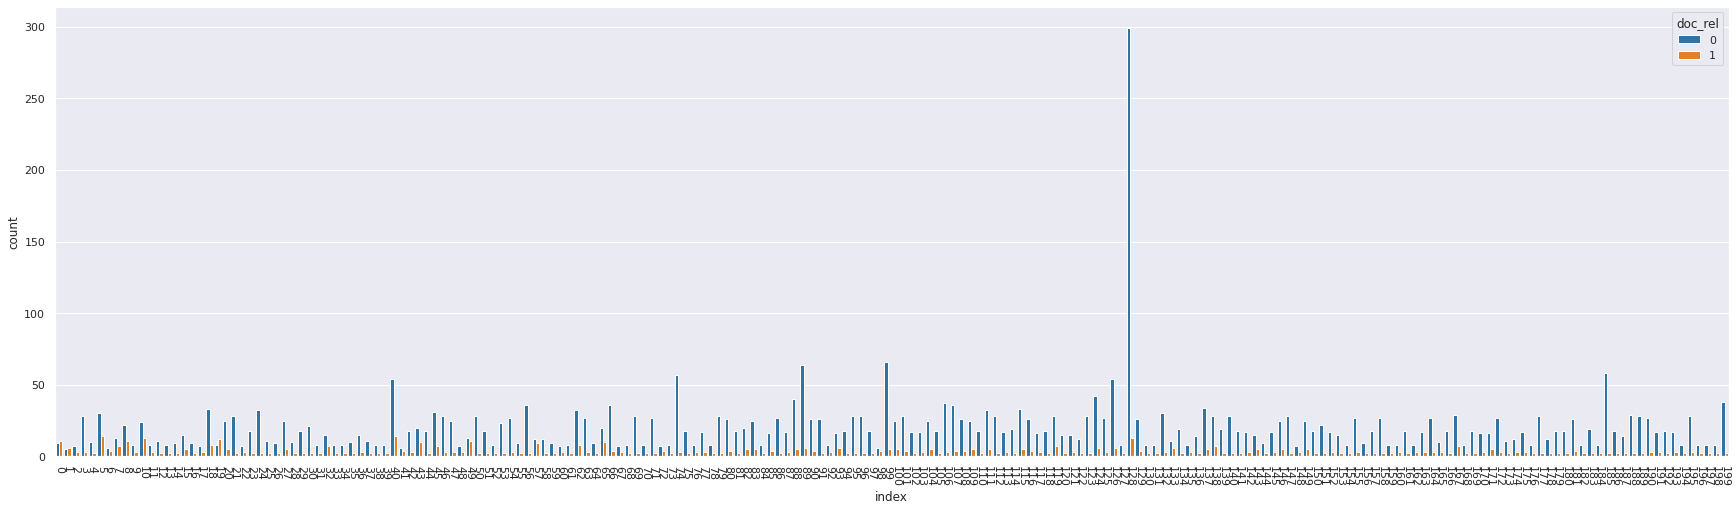

In [263]:
data = allmerge[['index', 'qid','doc_rel', 'has_author']]
data[:100]
fig, ax =  plt.subplots(1,1,figsize = (30,8.27))

# sns.barplot(x ='qid', hue = 'doc_rel',  data = data[:100], ax=ax)
sns.countplot(x="index", hue="doc_rel", data=data, ax=ax)
sns.countplot(x="index", hue="doc_rel", data=data, ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation = -90)

In [272]:
data.head()


index    qid  doc_rel  has_author
0      0  91643        1        True
1      0  91643        0        True
2      0  91643        1        True
3      0  91643        0        True
4      0  91643        0        True

<AxesSubplot:xlabel='index'>

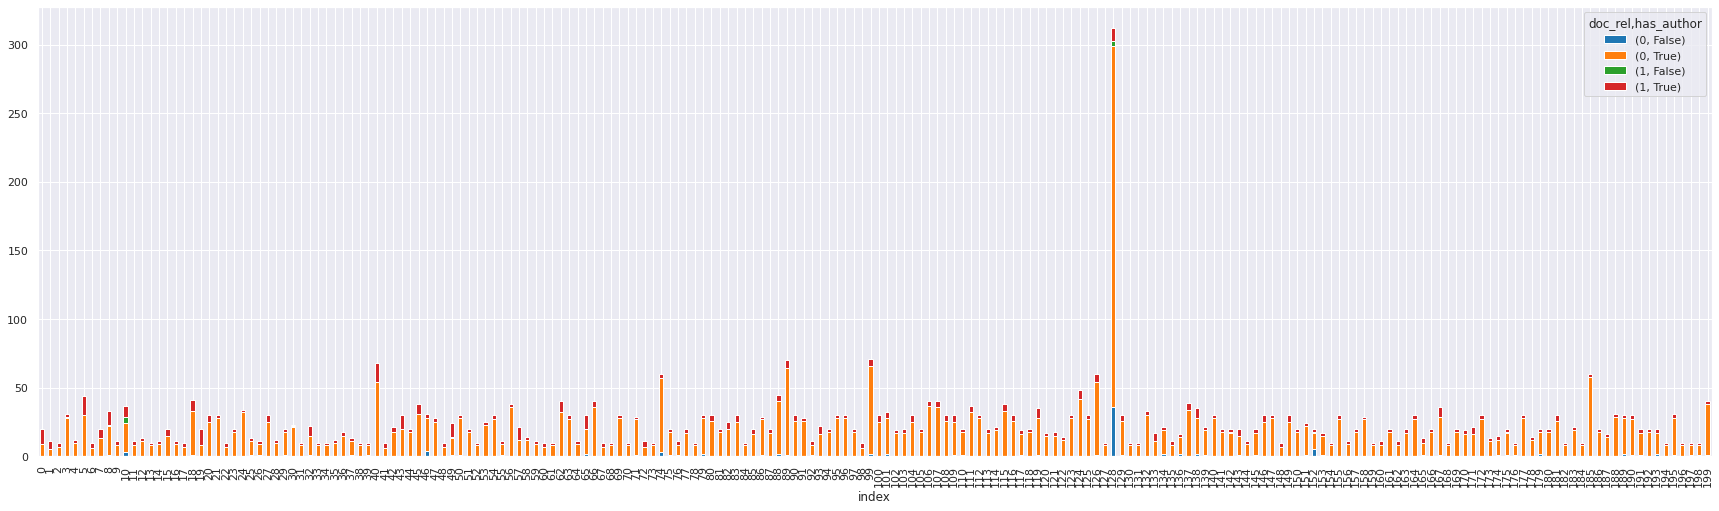

In [304]:
fig, ax =  plt.subplots(1,1,figsize = (30,8.27))

pd.crosstab(data['index'],[data['doc_rel'],data['has_author']]).plot(kind="bar",stacked=True,ax=ax)

In [309]:
pd.crosstab(data['index'],[data['doc_rel'],data['has_author']])

doc_rel        0           1      
has_author False True  False True 
index                             
0              0     9     0    11
1              0     5     0     6
2              0     7     0     3
3              0    28     1     2
4              0    10     0     2
...          ...   ...   ...   ...
195            1    27     0     3
196            0     8     0     2
197            1     7     0     2
198            1     7     0     2
199            1    37     0     2

[200 rows x 4 columns]

In [278]:
data.groupby(['qid','doc_rel','has_author']).count().head()

index
qid doc_rel has_author       
95  0       False          36
            True          263
    1       False           4
            True            9
612 0       True           26

In [298]:
forsns = data[['qid','doc_rel','has_author']].groupby(['qid','doc_rel']).count()
forsns.head()

has_author
qid doc_rel            
95  0               299
    1                13
612 0                26
    1                 4
657 0                38

In [285]:
forsns = data[['qid','doc_rel','has_author']].groupby(['qid','doc_rel','has_author']).count().reset_index()
forsns.head()

qid  doc_rel  has_author  index
0   95        0       False     36
1   95        0        True    263
2   95        1       False      4
3   95        1        True      9
4  612        0        True     26

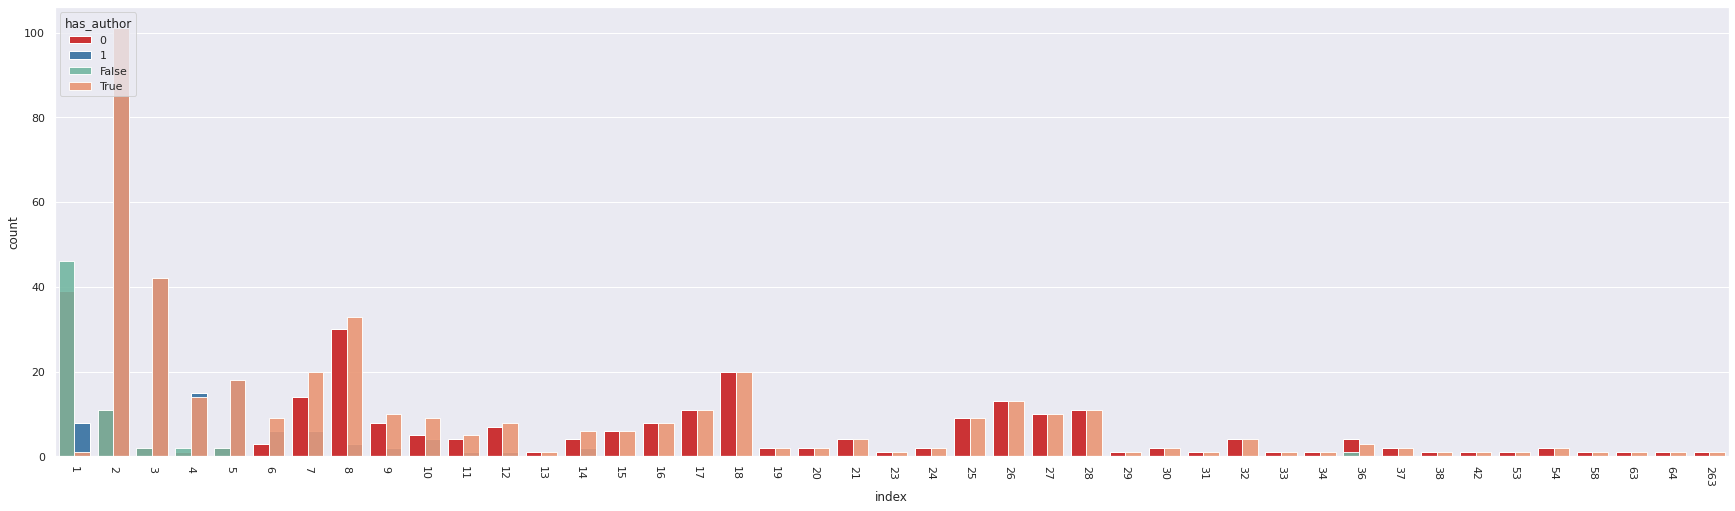

In [290]:
fig, ax =  plt.subplots(1,1,figsize = (30,8.27))

# sns.barplot(x ='qid', hue = 'doc_rel',  data = data[:100], ax=ax)
sns.countplot(x="index", hue="doc_rel", data=forsns, ax=ax,palette='Set1')
sns.countplot(x="index", y='has_author', hue="doc_rel", data=forsns, ax=ax,palette='Set2',alpha=0.9)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation = -90)

In [242]:
allmerge.set_index('index').plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='index'>

Error in callback <function flush_figures at 0x7fee3f775ef0> (for post_execute):


KeyboardInterrupt: 

In [313]:
data.head()

index    qid  doc_rel  has_author
0      0  91643        1        True
1      0  91643        0        True
2      0  91643        1        True
3      0  91643        0        True
4      0  91643        0        True

In [320]:
crossdata = pd.crosstab(data['index'],[data['doc_rel'],data['has_author']])

In [321]:
crossdata.head().columns

MultiIndex([(0, False),
            (0,  True),
            (1, False),
            (1,  True)],
           names=['doc_rel', 'has_author'])

In [324]:
crossdata[(0,False)].to_list()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 3,
 1,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 36,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 5,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 2,
 0,
 1,
 0,
 1,
 1,
 1]

In [325]:
crossdata.head().index.to_list()

[0, 1, 2, 3, 4]

In [342]:
np.arange(len(rel_has_author)*2,step=2)

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206,
       208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232,
       234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258,
       260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284,
       286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310,
       312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336,
       338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 36

[11  6  3  2  2 14  4  7 10  3  8  3  2  2  2  5  2  3  8 12  5  2  3  2
  2  2  2  5  2  2  1  2  7  2  2  2  3  2  2  2 14  4  3 10  2  7  3  3
  3 10  2  2  2  2  3  2  2  9  2  2  3  2  8  3  2 10  4  3  2  2  2  2
  4  2  3  2  3  3  2  2  4  2  5  5  2  4  2  3  5  6  4  2  3  6  2  2
  2  2  4  5  5  4  2  3  5  2  3  4  4  5  2  5  2  3  2  5  4  3  2  7
  2  3  2  2  6  3  6  2  9  4  2  2  3  6  2  3  2  5  7  2  2  2  2  5
  2  3  5  2  3  5  2  2  2  2  2  3  2  2  2  2  3  2  3  3  3  3  2  7
  2  2  3  5  3  2  3  2  2  2  2  2  2  4  2  2  2  2  2  2  2  2  3  3
  2  3  2  3  2  2  2  2]


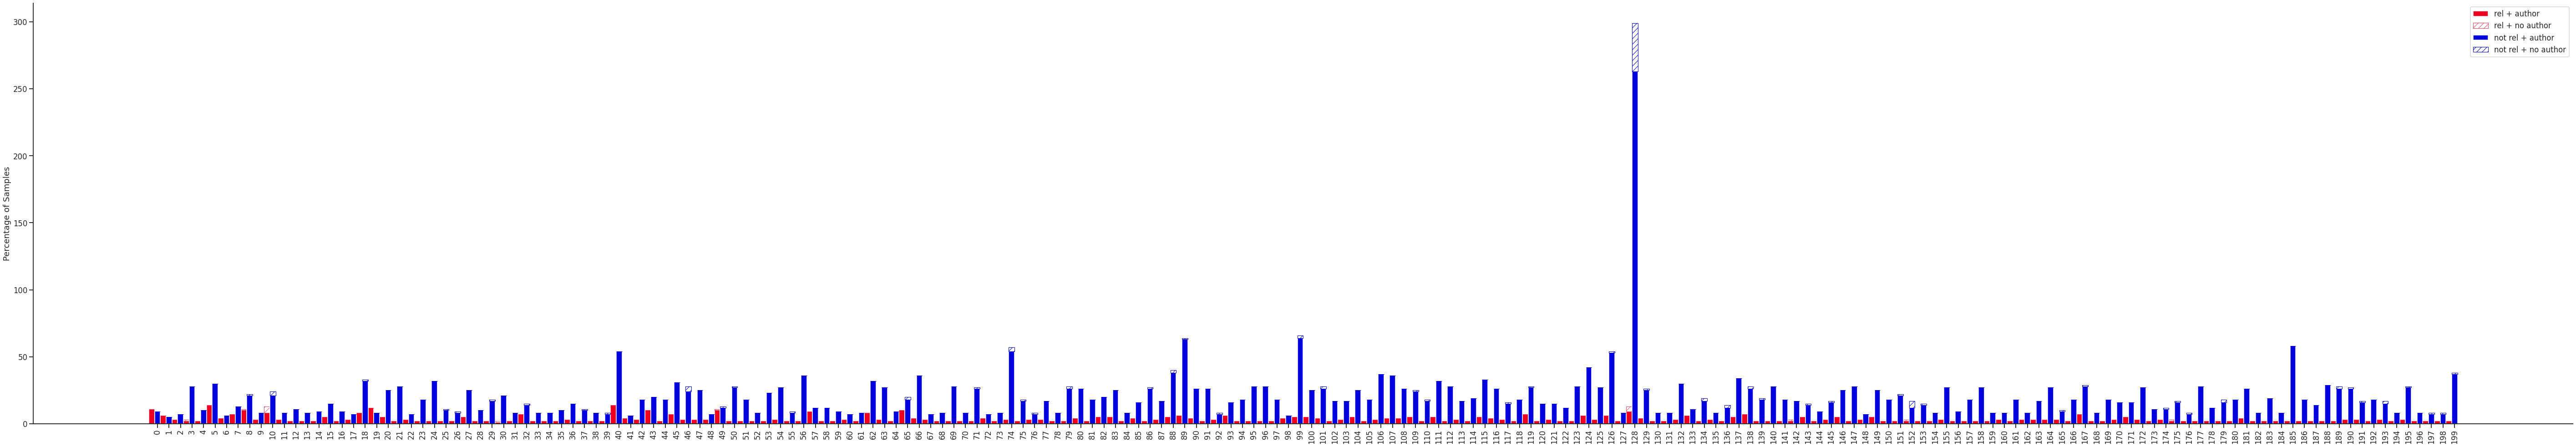

In [352]:
import numpy as np

rel_has_author = np.array(crossdata[(1,True)].to_list())
rel_not_has_author = np.array(crossdata[(1,False)].to_list())
nonrel_has_author = np.array(crossdata[(0,True)].to_list())
nonrel_not_has_author = np.array(crossdata[(0,False)].to_list())
qid = crossdata.index.to_list()

with sns.axes_style("white"):
    sns.set(rc={'figure.figsize':(100,17)})
    sns.set_style("ticks")
    sns.set_context("talk")
    
    # plot details
    bar_width = 5
    epsilon = .015
    line_width = 1
    opacity = 0.7
    pos_bar_positions = np.arange(len(rel_has_author)*2*bar_width,step=2*bar_width)
    neg_bar_positions = pos_bar_positions + bar_width

    # make bar plots
    rel_has_author_bar = plt.bar(pos_bar_positions, rel_has_author, bar_width,
                              color='#ED0020',
                              label='rel + author')
    print(rel_has_author)
    rel_not_has_author_bar = plt.bar(pos_bar_positions, rel_not_has_author, bar_width-epsilon,
                              bottom=rel_has_author,
                              alpha=opacity,
                              color='white',
                              edgecolor='#ED0020',
                              linewidth=line_width,
                              hatch='//',
                              label='rel + no author')
    
    nonrel_has_author_bar = plt.bar(neg_bar_positions, nonrel_has_author, bar_width,
                              color='#0000DD',
                              label='not rel + author')
    nonrel_not_has_author_bar = plt.bar(neg_bar_positions, nonrel_not_has_author, bar_width-epsilon,
                              bottom=nonrel_has_author,
                              color="white",
                              hatch='//',
                              edgecolor='#0000DD',
                              ecolor="#0000DD",
                              linewidth=line_width,
                              label='not rel + no author')
    
    plt.xticks(neg_bar_positions, qid, rotation=90)
    plt.ylabel('Percentage of Samples')
    plt.legend(loc='best')
    sns.despine()

In [358]:
crossdata.index.to_list()[-10:]

[190, 191, 192, 193, 194, 195, 196, 197, 198, 199]

In [364]:
crossdata.index.to_list()[-10:]

[190, 191, 192, 193, 194, 195, 196, 197, 198, 199]

In [366]:
crossdata.index.to_list()[len(crossdata.index.to_list())-10:len(crossdata.index.to_list())]

[190, 191, 192, 193, 194, 195, 196, 197, 198, 199]

In [365]:
crossdata.index.to_list()[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

[11  6  3  2  2 14  4  7 10  3]


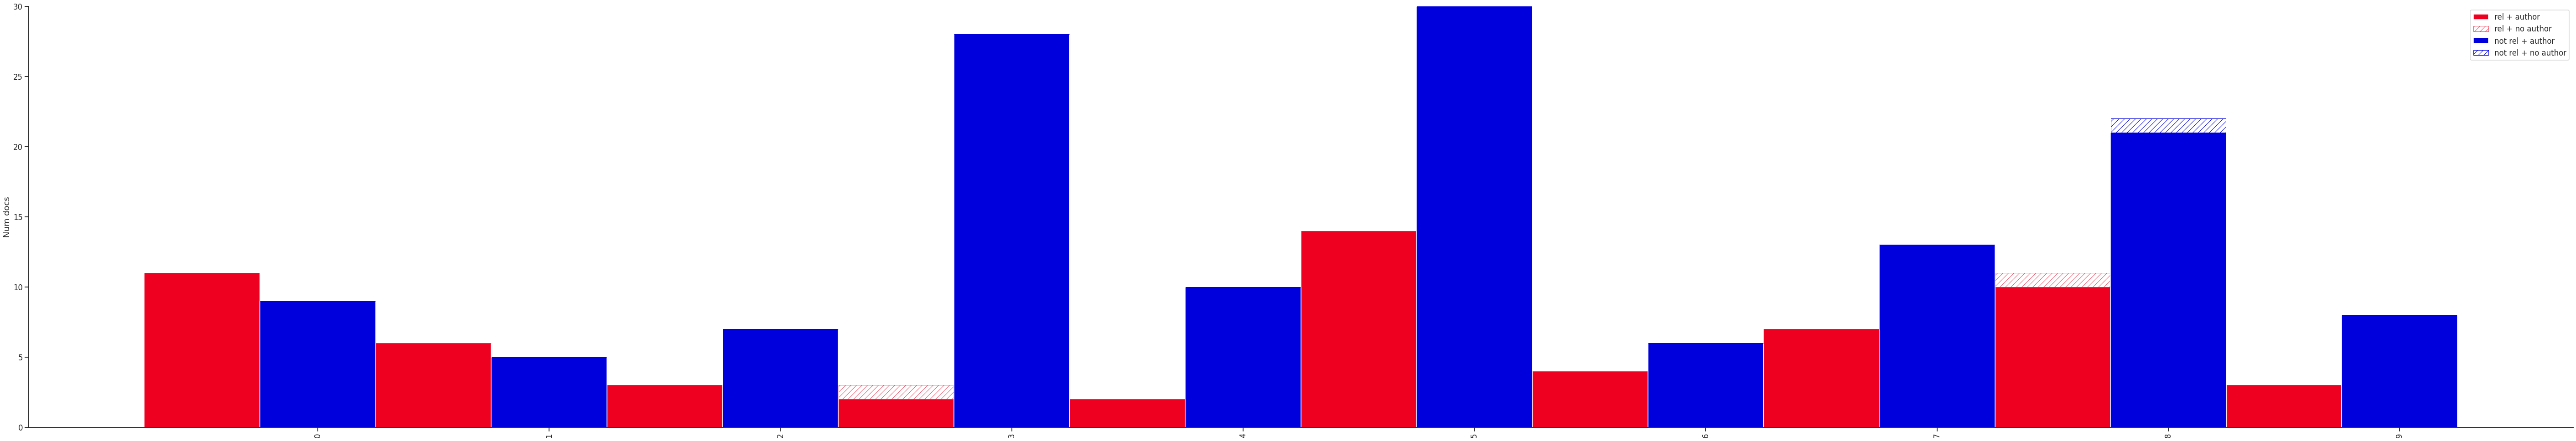

In [368]:
plot_has_authors(crossdata)

[3 3 2 3 2 3 2 2 2 2]


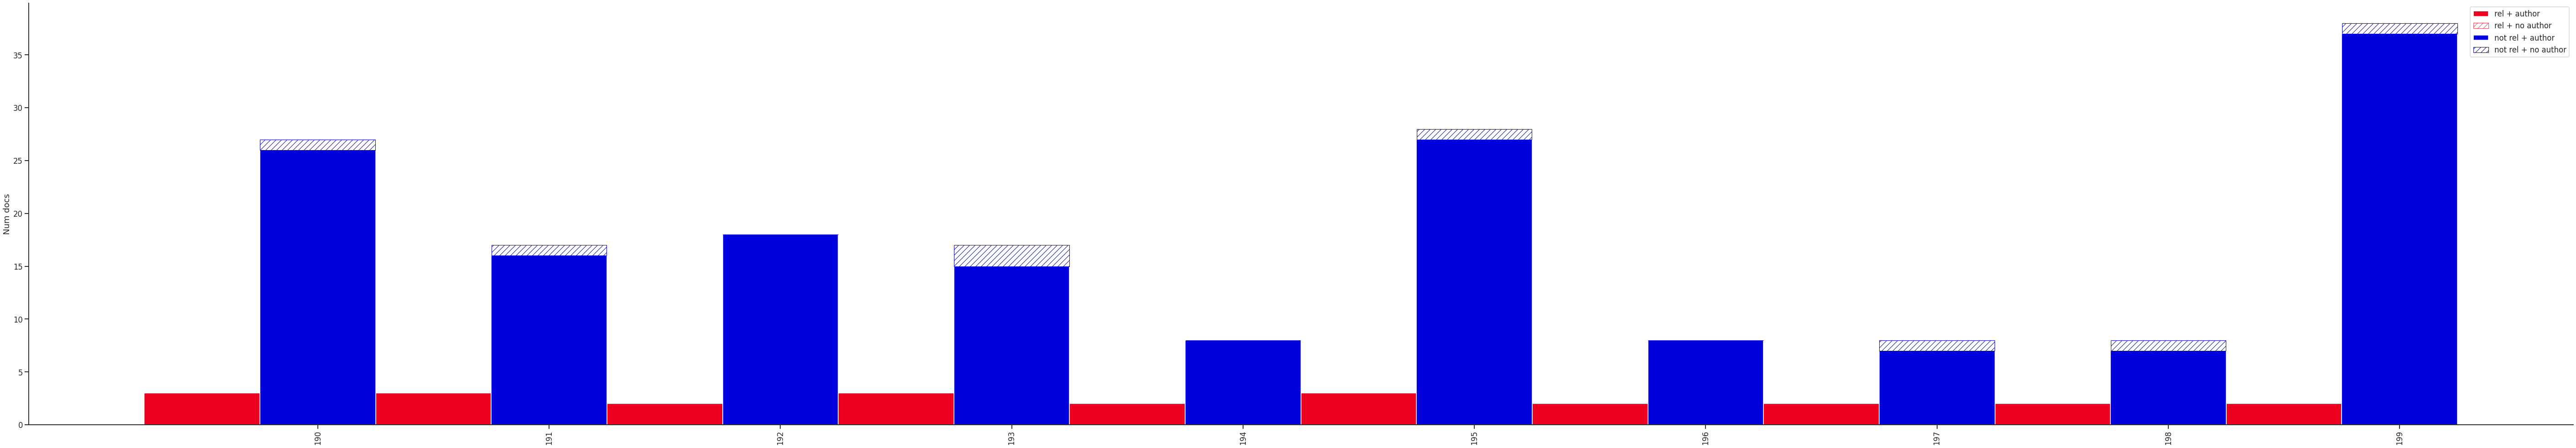

In [369]:
plot_has_authors(crossdata,asc=False)

In [367]:
import numpy as np

def plot_has_authors(crossdata,k=10,asc=True):
    if asc:
        slstart = 0
        slend = k
    else:
        slstart = len(crossdata.index.to_list())-k
        slend = len(crossdata.index.to_list())
    
    
    rel_has_author = np.array(crossdata[(1,True)].to_list()[slstart:slend])
    rel_not_has_author = np.array(crossdata[(1,False)].to_list()[slstart:slend])
    nonrel_has_author = np.array(crossdata[(0,True)].to_list()[slstart:slend])
    nonrel_not_has_author = np.array(crossdata[(0,False)].to_list()[slstart:slend])
    qid = crossdata.index.to_list()[slstart:slend]

    with sns.axes_style("white"):
        sns.set(rc={'figure.figsize':(100,17)})
        sns.set_style("ticks")
        sns.set_context("talk")

        # plot details
        bar_width = 4
        epsilon = .015
        line_width = 1
        opacity = 0.7
        pos_bar_positions = np.arange(len(rel_has_author)*2*bar_width,step=2*bar_width)
        neg_bar_positions = pos_bar_positions + bar_width

        # make bar plots
        rel_has_author_bar = plt.bar(pos_bar_positions, rel_has_author, bar_width,
                                  color='#ED0020',
                                  label='rel + author')
        print(rel_has_author)
        rel_not_has_author_bar = plt.bar(pos_bar_positions, rel_not_has_author, bar_width-epsilon,
                                  bottom=rel_has_author,
                                  alpha=opacity,
                                  color='white',
                                  edgecolor='#ED0020',
                                  linewidth=line_width,
                                  hatch='//',
                                  label='rel + no author')

        nonrel_has_author_bar = plt.bar(neg_bar_positions, nonrel_has_author, bar_width,
                                  color='#0000DD',
                                  label='not rel + author')
        nonrel_not_has_author_bar = plt.bar(neg_bar_positions, nonrel_not_has_author, bar_width-epsilon,
                                  bottom=nonrel_has_author,
                                  color="white",
                                  hatch='//',
                                  edgecolor='#0000DD',
                                  ecolor="#0000DD",
                                  linewidth=line_width,
                                  label='not rel + no author')

        plt.xticks(neg_bar_positions, qid, rotation=90)
        plt.ylabel('Num docs')
        plt.legend(loc='best')
        sns.despine()

In [386]:
dat = crossdata.unstack().reset_index().rename({0:'count'},axis=1)
# dat[dat['index'] <= 10]

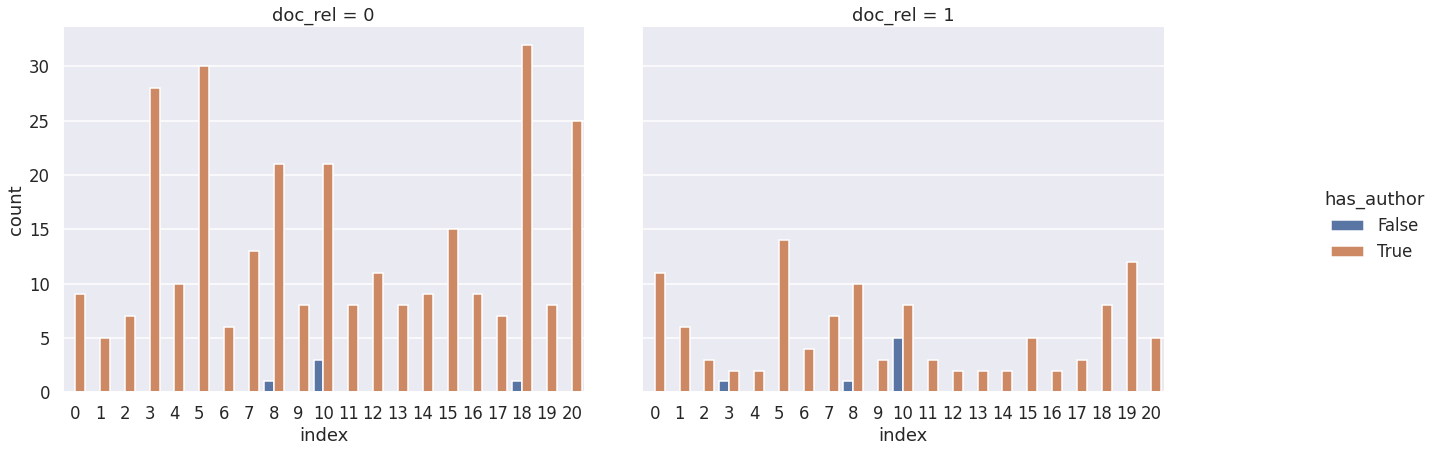

In [397]:
dat = crossdata.unstack().reset_index().rename({0:'count'},axis=1)
# fig, ax = plt.subplots(1,1,figsize = (17.7,8.27))

g = sns.catplot(x="index", y="count",
                hue="has_author", col="doc_rel",
                data=dat[dat['index'] <= 20], kind="bar",
                height=4, aspect=1)
g.fig.set_size_inches(22,8.27)


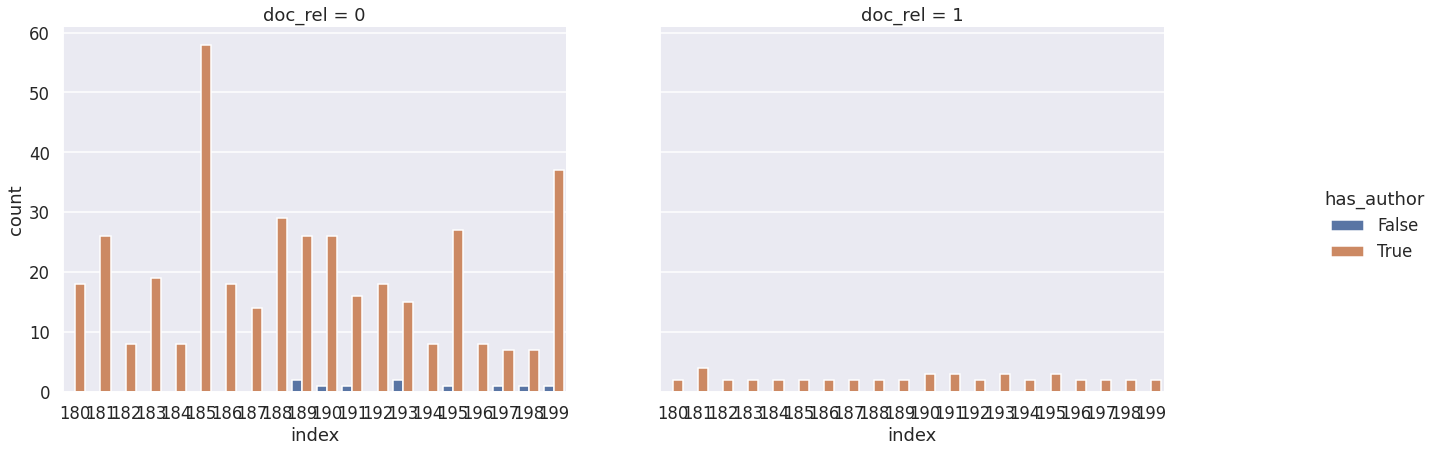

In [398]:
g = sns.catplot(x="index", y="count",
                hue="has_author", col="doc_rel",
                data=dat[dat['index'] >= len(dat['index'].unique()) - 20], kind="bar",
                height=4, aspect=1)
g.fig.set_size_inches(22,8.27)

Hypothesis was: bottom queries have many items without author


- Bottom queries mainly have nonrel items without author
- Top queries have both rel and nonrel items without author

Still to check: 
- for top/bottom queries, are the top non-author documents mainly relevant?
    - for each query for each rank, how often does a no-author document appear there and is it relevant or not?
    
    
- for top/bottom queries, compare the estimated relevance to the actual relevance
    --> estimated relevance is used to compute the h_score
    --> if the estimated relevance is low compared to the actual relevance the h-score will be lower than it should be

- for top/bottom queries, compare the estimated relevance to the actual relevance
    --> estimated relevance is used to compute the h_score
    --> if the estimated relevance is low compared to the actual relevance the h-score will be lower than it should be

In [411]:
est_rel_meta.describe()

qid  est_relevance
count    4805.000000    4805.000000
mean    37246.231009       0.156557
std     32685.903930       0.050937
min        95.000000       0.000677
25%     10454.000000       0.116971
50%     27924.000000       0.163918
75%     55188.000000       0.194750
max    128604.000000       0.262877

In [412]:
reldf.describe()

qid      doc_rel
count    4814.000000  4814.000000
mean    37232.632322     0.144786
std     32691.996302     0.351922
min        95.000000     0.000000
25%     10454.000000     0.000000
50%     27924.000000     0.000000
75%     55188.000000     0.000000
max    128604.000000     1.000000

In [415]:
pd.merge(est_rel_meta,reldf,on=['qid','doc_id'],how='outer').describe()

qid  est_relevance      doc_rel
count    4814.000000    4805.000000  4814.000000
mean    37232.632322       0.156557     0.144786
std     32691.996302       0.050937     0.351922
min        95.000000       0.000677     0.000000
25%     10454.000000       0.116971     0.000000
50%     27924.000000       0.163918     0.000000
75%     55188.000000       0.194750     0.000000
max    128604.000000       0.262877     1.000000

In [416]:
est_and_rel = pd.merge(est_rel_meta,reldf,on=['qid','doc_id'],how='outer').fillna(0)
est_and_rel.head()

qid                                    doc_id  est_relevance  \
0  9087  40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4       0.131015   
1  9087  008a2a2c765485af2e035a2572ba9fc1102eabff       0.208199   
2  9087  4a1472c575488ed9acee6c5481f68b95a0c34092       0.129001   
3  9087  ff8df0745136fb183ea72b783ff38f8a7ad5ceec       0.179983   
4  9087  90605deb1da5e3d5548da12dc130fc0341a6a255       0.157544   

              query  doc_rel  
0  lepidium sativum        1  
1  lepidium sativum        1  
2  lepidium sativum        0  
3  lepidium sativum        0  
4  lepidium sativum        0

<AxesSubplot:xlabel='doc_rel', ylabel='est_relevance'>

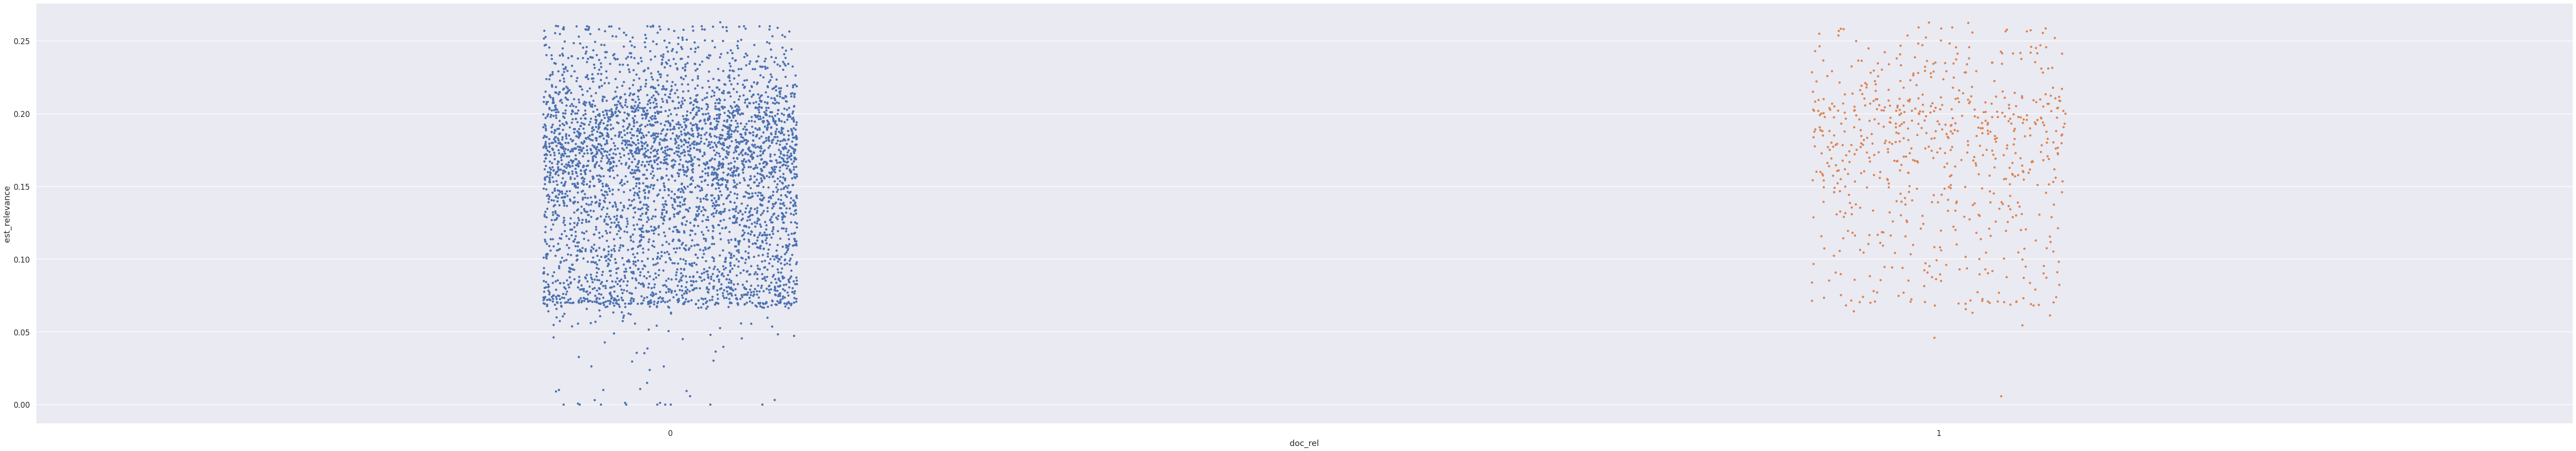

In [417]:
 sns.stripplot(x="doc_rel", y="est_relevance", data=est_and_rel)

interestingly, none of the estimated values are very high? why is that? and there are three points that have rel 1 but are estimated very low, interesting to see if those cause some low results in the rankings

## Bibliography

[1] Buckley, ‘Reliable Information Access Final Workshop Report’.